In [1]:
import pandas as pd
from orbit.models import ETS
from orbit.models import DLT
from orbit.diagnostics.backtest import BackTester
from orbit.models import KTR
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from math import sqrt
from concurrent.futures import ThreadPoolExecutor
import concurrent
import json
from typing import Any, Callable, Dict, Tuple
import itertools
import sys
from pathlib import Path
from tqdm import tqdm

parent_dir = Path.cwd().parent.parent

if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.helpers import store_model
from shared.helpers import store_predictions_and_create_graph

/home/samuell/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "period"
target_column = "value"
df = pd.read_csv(file_path, parse_dates=[date_column])
df = df[[date_column, target_column, "value_30_hours_ago"]]
df = df.groupby(date_column).sum().reset_index()
df = df.dropna()

data_length = len(df)
train_split = 0.9
train = df.iloc[:int(data_length*train_split)]
test = df.iloc[int(data_length*train_split):]

In [3]:
def evaluate_grid(
    model_function: Callable[[Dict[str, Any], str, str], Any],
    grid: Dict[str, Any],
    train: pd.DataFrame,
    date_column: str,
    target_column: str,
) -> Tuple[Dict[str, Any], float]:
    """
    Evaluate a forecasting model on a given parameter grid.

    This function uses a model creation function to initialize a model with the provided
    grid of parameters, performs backtesting using the provided training data, and computes
    the root mean squared error (RMSE) of the predictions.

    Parameters:
    - model_function (Callable[[Dict[str, Any], str, str], Any]): A function that creates
      a model instance. It should accept a parameter grid, a date column name, and a target
      column name.
    - grid (Dict[str, Any]): A dictionary containing the parameters for the model.
    - train (pd.DataFrame): The training dataset as a Pandas DataFrame.
    - date_column (str): The name of the column in 'train' that contains the date information.
    - target_column (str): The name of the target column in 'train'.

    Returns:
    - Tuple[Dict[str, Any], float]: A tuple containing the grid of parameters and the
      corresponding RMSE score.
    """
    model = model_function(grid, date_column, target_column)

    bt = BackTester(
        df=train, model=model, forecast_len=90, n_splits=5, window_type="rolling"
    )

    bt.fit_predict()
    predicted_df = bt.get_predicted_df()

    score = sqrt(mean_squared_error(predicted_df["actual"], predicted_df["prediction"]))
    return grid, score

In [4]:
param_grid = {
    "seasonality": [24, 7*24],
    "level_sm_input": [None, 0, 0.3, 0.5, 0.8, 1],
    "seasonality_sm_input": [0, 0.3, 0.5, 0.8, 1],
}
param_values = list(param_grid.values())

all_combinations = list(itertools.product(*param_values))

combinations_as_dicts = [
    dict(zip(param_grid.keys(), combination)) for combination in all_combinations
]

In [5]:
ets_scores = json.load(open("ets_scores.json"))

In [6]:
ets_scores

{'{"seasonality": 24, "level_sm_input": null, "seasonality_sm_input": 0}': 2728.6962145423086}

In [7]:
def ets_function(grid: Dict[str, Any], date_column: str, target_column: str):
    """
    Create an ETS model with the specified parameters.

    Parameters:
    - grid (Dict[str, Any]): A dictionary containing the parameters for the ETS model.
    - date_column (str): The name of the date column.
    - target_column (str): The name of the target column.

    Returns:
    - An instance of the ETS model configured with the given parameters.
    """
    return ETS(
        date_col=date_column,
        response_col=target_column,
        prediction_percentiles=[5, 95],
        seed=1,
        **grid
    )

for option in tqdm(combinations_as_dicts):
    print(option)
    if json.dumps(option) in ets_scores:
        continue
    _, score = evaluate_grid(ets_function, option, train, date_column, target_column)
    ets_scores[json.dumps(option)] = score
    with open("ets_scores.json", "w") as f:
        json.dump(ets_scores, f)

  0%|          | 0/60 [00:00<?, ?it/s]

2024-05-01 16:27:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': None, 'seasonality_sm_input': 0}
{'seasonality': 24, 'level_sm_input': None, 'seasonality_sm_input': 0.3}
































chain 1 |██████████| 01:58 Sampling completed                     
chain 2 |██████████| 01:58 Sampling completed                     
chain 3 |██████████| 01:58 Sampling completed                     
chain 4 |██████████| 01:58 Sampling completed                     

2024-05-01 16:29:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:22 Sampling completed                     
chain 2 |██████████| 02:22 Sampling completed                     
chain 3 |██████████| 02:22 Sampling completed                     
chain 4 |██████████| 02:22 Sampling completed                     

2024-05-01 16:31:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































chain 1 |██████████| 03:55 Sampling completed                     
chain 2 |██████████| 03:55 Sampling completed                     
chain 3 |██████████| 03:55 Sampling completed                     
chain 4 |██████████| 03:55 Sampling completed                     

2024-05-01 16:35:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 03:38 Sampling completed                     
chain 2 |██████████| 03:38 Sampling completed                     
chain 3 |██████████| 03:38 Sampling completed                     
chain 4 |██████████| 03:38 Sampling completed                     

2024-05-01 16:39:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 03:37 Sampling completed                     
chain 2 |██████████| 03:37 Sampling completed                     
chain 3 |██████████| 03:37 Sampling completed                     
chain 4 |██████████| 03:37 Sampling completed                     

  3%|▎         | 2/60 [15:44<7:36:40, 472.42s/it]2024-05-01 16:42:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': None, 'seasonality_sm_input': 0.5}






































chain 1 |██████████| 03:33 Sampling completed                     
chain 2 |██████████| 03:33 Sampling completed                     
chain 3 |██████████| 03:33 Sampling completed                     
chain 4 |██████████| 03:33 Sampling completed                     

2024-05-01 16:46:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 03:42 Sampling completed                     
chain 2 |██████████| 03:42 Sampling completed                     
chain 3 |██████████| 03:42 Sampling completed                     
chain 4 |██████████| 03:42 Sampling completed                     

2024-05-01 16:50:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 03:33 Sampling completed                     
chain 2 |██████████| 03:33 Sampling completed                     
chain 3 |██████████| 03:33 Sampling completed                     
chain 4 |██████████| 03:33 Sampling completed                     

2024-05-01 16:53:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 04:06 Sampling completed                     
chain 2 |██████████| 04:06 Sampling completed                     
chain 3 |██████████| 04:06 Sampling completed                     
chain 4 |██████████| 04:06 Sampling completed                     

2024-05-01 16:58:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 03:35 Sampling completed                     
chain 2 |██████████| 03:35 Sampling completed                     
chain 3 |██████████| 03:35 Sampling completed                     
chain 4 |██████████| 03:35 Sampling completed                     

  5%|▌         | 3/60 [34:30<11:47:22, 744.60s/it]2024-05-01 17:01:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': None, 'seasonality_sm_input': 0.8}






































chain 1 |██████████| 03:41 Sampling completed                     
chain 2 |██████████| 03:41 Sampling completed                     
chain 3 |██████████| 03:41 Sampling completed                     
chain 4 |██████████| 03:41 Sampling completed                     

2024-05-01 17:05:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 04:16 Sampling completed                     
chain 2 |██████████| 04:16 Sampling completed                     
chain 3 |██████████| 04:16 Sampling completed                     
chain 4 |██████████| 04:16 Sampling completed                     

2024-05-01 17:09:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 03:54 Sampling completed                     
chain 2 |██████████| 03:54 Sampling completed                     
chain 3 |██████████| 03:54 Sampling completed                     
chain 4 |██████████| 03:54 Sampling completed                     

2024-05-01 17:13:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 03:42 Sampling completed                     
chain 2 |██████████| 03:42 Sampling completed                     
chain 3 |██████████| 03:42 Sampling completed                     
chain 4 |██████████| 03:42 Sampling completed                     

2024-05-01 17:17:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































chain 1 |██████████| 03:36 Sampling completed                     
chain 2 |██████████| 03:36 Sampling completed                     
chain 3 |██████████| 03:36 Sampling completed                     
chain 4 |██████████| 03:36 Sampling completed                     

  7%|▋         | 4/60 [53:55<14:01:25, 901.53s/it]2024-05-01 17:21:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': None, 'seasonality_sm_input': 1}






































chain 1 |██████████| 03:25 Sampling completed                     
chain 2 |██████████| 03:25 Sampling completed                     
chain 3 |██████████| 03:25 Sampling completed                     
chain 4 |██████████| 03:25 Sampling completed                     

2024-05-01 17:24:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































chain 1 |██████████| 04:08 Sampling completed                     
chain 2 |██████████| 04:08 Sampling completed                     
chain 3 |██████████| 04:08 Sampling completed                     
chain 4 |██████████| 04:08 Sampling completed                     

2024-05-01 17:28:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 03:30 Sampling completed                     
chain 2 |██████████| 03:30 Sampling completed                     
chain 3 |██████████| 03:30 Sampling completed                     
chain 4 |██████████| 03:30 Sampling completed                     

2024-05-01 17:32:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 03:20 Sampling completed                     
chain 2 |██████████| 03:20 Sampling completed                     
chain 3 |██████████| 03:20 Sampling completed                     
chain 4 |██████████| 03:20 Sampling completed                     

2024-05-01 17:35:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 03:23 Sampling completed                     
chain 2 |██████████| 03:23 Sampling completed                     
chain 3 |██████████| 03:23 Sampling completed                     
chain 4 |██████████| 03:23 Sampling completed                     

  8%|▊         | 5/60 [1:11:56<14:43:38, 963.97s/it]2024-05-01 17:39:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': 0, 'seasonality_sm_input': 0}






































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

2024-05-01 17:39:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

2024-05-01 17:39:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

2024-05-01 17:39:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2024-05-01 17:40:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     

 10%|█         | 6/60 [1:13:08<10:00:58, 667.75s/it]2024-05-01 17:40:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': 0, 'seasonality_sm_input': 0.3}



































chain 1 |██████████| 02:21 Sampling completed                     
chain 2 |██████████| 02:21 Sampling completed                     
chain 3 |██████████| 02:21 Sampling completed                     
chain 4 |██████████| 02:21 Sampling completed                     

2024-05-01 17:42:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     

2024-05-01 17:44:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:30 Sampling completed                     
chain 2 |██████████| 01:30 Sampling completed                     
chain 3 |██████████| 01:30 Sampling completed                     
chain 4 |██████████| 01:30 Sampling completed                     

2024-05-01 17:46:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:33 Sampling completed                     
chain 2 |██████████| 01:33 Sampling completed                     
chain 3 |██████████| 01:33 Sampling completed                     
chain 4 |██████████| 01:33 Sampling completed                     

2024-05-01 17:47:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:28 Sampling completed                     
chain 2 |██████████| 01:28 Sampling completed                     
chain 3 |██████████| 01:28 Sampling completed                     
chain 4 |██████████| 01:28 Sampling completed                     

 12%|█▏        | 7/60 [1:21:59<9:11:00, 623.79s/it] 2024-05-01 17:49:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': 0, 'seasonality_sm_input': 0.5}
































chain 1 |██████████| 01:29 Sampling completed                     
chain 2 |██████████| 01:29 Sampling completed                     
chain 3 |██████████| 01:29 Sampling completed                     
chain 4 |██████████| 01:29 Sampling completed                     

2024-05-01 17:50:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:29 Sampling completed                     
chain 2 |██████████| 01:29 Sampling completed                     
chain 3 |██████████| 01:29 Sampling completed                     
chain 4 |██████████| 01:29 Sampling completed                     

2024-05-01 17:52:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:31 Sampling completed                     
chain 2 |██████████| 01:31 Sampling completed                     
chain 3 |██████████| 01:31 Sampling completed                     
chain 4 |██████████| 01:31 Sampling completed                     

2024-05-01 17:53:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:36 Sampling completed                     
chain 2 |██████████| 01:36 Sampling completed                     
chain 3 |██████████| 01:36 Sampling completed                     
chain 4 |██████████| 01:36 Sampling completed                     

2024-05-01 17:55:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:32 Sampling completed                     
chain 2 |██████████| 01:32 Sampling completed                     
chain 3 |██████████| 01:32 Sampling completed                     
chain 4 |██████████| 01:32 Sampling completed                     

 13%|█▎        | 8/60 [1:29:44<8:17:16, 573.77s/it]2024-05-01 17:56:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': 0, 'seasonality_sm_input': 0.8}
































chain 1 |██████████| 01:24 Sampling completed                     
chain 2 |██████████| 01:24 Sampling completed                     
chain 3 |██████████| 01:24 Sampling completed                     
chain 4 |██████████| 01:24 Sampling completed                     

2024-05-01 17:58:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:27 Sampling completed                     
chain 2 |██████████| 01:27 Sampling completed                     
chain 3 |██████████| 01:27 Sampling completed                     
chain 4 |██████████| 01:27 Sampling completed                     

2024-05-01 17:59:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:29 Sampling completed                     
chain 2 |██████████| 01:29 Sampling completed                     
chain 3 |██████████| 01:29 Sampling completed                     
chain 4 |██████████| 01:29 Sampling completed                     

2024-05-01 18:01:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:27 Sampling completed                     
chain 2 |██████████| 01:27 Sampling completed                     
chain 3 |██████████| 01:27 Sampling completed                     
chain 4 |██████████| 01:27 Sampling completed                     

2024-05-01 18:02:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:28 Sampling completed                     
chain 2 |██████████| 01:28 Sampling completed                     
chain 3 |██████████| 01:28 Sampling completed                     
chain 4 |██████████| 01:28 Sampling completed                     

 15%|█▌        | 9/60 [1:37:05<7:32:47, 532.69s/it]2024-05-01 18:04:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': 0, 'seasonality_sm_input': 1}
































chain 1 |██████████| 01:22 Sampling completed                     
chain 2 |██████████| 01:22 Sampling completed                     
chain 3 |██████████| 01:22 Sampling completed                     
chain 4 |██████████| 01:22 Sampling completed                     

2024-05-01 18:05:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:29 Sampling completed                     
chain 2 |██████████| 01:29 Sampling completed                     
chain 3 |██████████| 01:29 Sampling completed                     
chain 4 |██████████| 01:29 Sampling completed                     

2024-05-01 18:07:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:33 Sampling completed                     
chain 2 |██████████| 01:33 Sampling completed                     
chain 3 |██████████| 01:33 Sampling completed                     
chain 4 |██████████| 01:33 Sampling completed                     

2024-05-01 18:08:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:32 Sampling completed                     
chain 2 |██████████| 01:32 Sampling completed                     
chain 3 |██████████| 01:32 Sampling completed                     
chain 4 |██████████| 01:32 Sampling completed                     

2024-05-01 18:10:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:26 Sampling completed                     
chain 2 |██████████| 01:26 Sampling completed                     
chain 3 |██████████| 01:26 Sampling completed                     
chain 4 |██████████| 01:26 Sampling completed                     

 17%|█▋        | 10/60 [1:44:35<7:02:42, 507.25s/it]2024-05-01 18:11:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': 0.3, 'seasonality_sm_input': 0}
































chain 1 |██████████| 01:27 Sampling completed                     
chain 2 |██████████| 01:27 Sampling completed                     
chain 3 |██████████| 01:27 Sampling completed                     
chain 4 |██████████| 01:27 Sampling completed                     

2024-05-01 18:13:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:26 Sampling completed                     
chain 2 |██████████| 01:26 Sampling completed                     
chain 3 |██████████| 01:26 Sampling completed                     
chain 4 |██████████| 01:26 Sampling completed                     

2024-05-01 18:14:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:24 Sampling completed                     
chain 2 |██████████| 01:24 Sampling completed                     
chain 3 |██████████| 01:24 Sampling completed                     
chain 4 |██████████| 01:24 Sampling completed                     

2024-05-01 18:16:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:28 Sampling completed                     
chain 2 |██████████| 01:28 Sampling completed                     
chain 3 |██████████| 01:28 Sampling completed                     
chain 4 |██████████| 01:28 Sampling completed                     

2024-05-01 18:17:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:28 Sampling completed                     
chain 2 |██████████| 01:28 Sampling completed                     
chain 3 |██████████| 01:28 Sampling completed                     
chain 4 |██████████| 01:28 Sampling completed                     

 18%|█▊        | 11/60 [1:51:55<6:37:39, 486.93s/it]2024-05-01 18:19:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': 0.3, 'seasonality_sm_input': 0.3}
































chain 1 |██████████| 01:50 Sampling completed                     
chain 2 |██████████| 01:50 Sampling completed                     
chain 3 |██████████| 01:50 Sampling completed                     
chain 4 |██████████| 01:50 Sampling completed                     

2024-05-01 18:20:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:56 Sampling completed                     
chain 2 |██████████| 01:56 Sampling completed                     
chain 3 |██████████| 01:56 Sampling completed                     
chain 4 |██████████| 01:56 Sampling completed                     

2024-05-01 18:22:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:51 Sampling completed                     
chain 2 |██████████| 01:51 Sampling completed                     
chain 3 |██████████| 01:51 Sampling completed                     
chain 4 |██████████| 01:51 Sampling completed                     

2024-05-01 18:24:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:46 Sampling completed                     
chain 2 |██████████| 01:46 Sampling completed                     
chain 3 |██████████| 01:46 Sampling completed                     
chain 4 |██████████| 01:46 Sampling completed                     

2024-05-01 18:26:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:43 Sampling completed                     
chain 2 |██████████| 01:43 Sampling completed                     
chain 3 |██████████| 01:43 Sampling completed                     
chain 4 |██████████| 01:43 Sampling completed                     

 20%|██        | 12/60 [2:01:09<6:45:42, 507.14s/it]2024-05-01 18:28:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': 0.3, 'seasonality_sm_input': 0.5}
































chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     

2024-05-01 18:30:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     

2024-05-01 18:32:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:52 Sampling completed                     
chain 2 |██████████| 01:52 Sampling completed                     
chain 3 |██████████| 01:52 Sampling completed                     
chain 4 |██████████| 01:52 Sampling completed                     

2024-05-01 18:33:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:46 Sampling completed                     
chain 2 |██████████| 01:46 Sampling completed                     
chain 3 |██████████| 01:46 Sampling completed                     
chain 4 |██████████| 01:46 Sampling completed                     

2024-05-01 18:35:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:55 Sampling completed                     
chain 2 |██████████| 01:55 Sampling completed                     
chain 3 |██████████| 01:55 Sampling completed                     
chain 4 |██████████| 01:55 Sampling completed                     

 22%|██▏       | 13/60 [2:10:29<6:49:49, 523.17s/it]2024-05-01 18:37:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': 0.3, 'seasonality_sm_input': 0.8}
































chain 1 |██████████| 01:50 Sampling completed                     
chain 2 |██████████| 01:50 Sampling completed                     
chain 3 |██████████| 01:50 Sampling completed                     
chain 4 |██████████| 01:50 Sampling completed                     

2024-05-01 18:39:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:52 Sampling completed                     
chain 2 |██████████| 01:52 Sampling completed                     
chain 3 |██████████| 01:52 Sampling completed                     
chain 4 |██████████| 01:52 Sampling completed                     

2024-05-01 18:41:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:50 Sampling completed                     
chain 2 |██████████| 01:50 Sampling completed                     
chain 3 |██████████| 01:50 Sampling completed                     
chain 4 |██████████| 01:50 Sampling completed                     

2024-05-01 18:43:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:52 Sampling completed                     
chain 2 |██████████| 01:52 Sampling completed                     
chain 3 |██████████| 01:52 Sampling completed                     
chain 4 |██████████| 01:52 Sampling completed                     

2024-05-01 18:45:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:50 Sampling completed                     
chain 2 |██████████| 01:50 Sampling completed                     
chain 3 |██████████| 01:50 Sampling completed                     
chain 4 |██████████| 01:50 Sampling completed                     

 23%|██▎       | 14/60 [2:19:51<6:50:05, 534.90s/it]2024-05-01 18:47:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': 0.3, 'seasonality_sm_input': 1}
































chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     

2024-05-01 18:48:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     

2024-05-01 18:50:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     

2024-05-01 18:52:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:51 Sampling completed                     
chain 2 |██████████| 01:51 Sampling completed                     
chain 3 |██████████| 01:51 Sampling completed                     
chain 4 |██████████| 01:51 Sampling completed                     

2024-05-01 18:54:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     

 25%|██▌       | 15/60 [2:28:59<6:44:10, 538.91s/it]2024-05-01 18:56:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': 0.5, 'seasonality_sm_input': 0}
































chain 1 |██████████| 01:34 Sampling completed                     
chain 2 |██████████| 01:34 Sampling completed                     
chain 3 |██████████| 01:34 Sampling completed                     
chain 4 |██████████| 01:34 Sampling completed                     

2024-05-01 18:57:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     

2024-05-01 18:59:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     

2024-05-01 19:01:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:41 Sampling completed                     
chain 2 |██████████| 01:41 Sampling completed                     
chain 3 |██████████| 01:41 Sampling completed                     
chain 4 |██████████| 01:41 Sampling completed                     

2024-05-01 19:03:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:41 Sampling completed                     
chain 2 |██████████| 01:41 Sampling completed                     
chain 3 |██████████| 01:41 Sampling completed                     
chain 4 |██████████| 01:41 Sampling completed                     

 27%|██▋       | 16/60 [2:37:33<6:29:39, 531.36s/it]2024-05-01 19:04:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': 0.5, 'seasonality_sm_input': 0.3}
































chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     

2024-05-01 19:06:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:46 Sampling completed                     
chain 2 |██████████| 01:46 Sampling completed                     
chain 3 |██████████| 01:46 Sampling completed                     
chain 4 |██████████| 01:46 Sampling completed                     

2024-05-01 19:08:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:48 Sampling completed                     
chain 2 |██████████| 01:48 Sampling completed                     
chain 3 |██████████| 01:48 Sampling completed                     
chain 4 |██████████| 01:48 Sampling completed                     

2024-05-01 19:10:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:55 Sampling completed                     
chain 2 |██████████| 01:55 Sampling completed                     
chain 3 |██████████| 01:55 Sampling completed                     
chain 4 |██████████| 01:55 Sampling completed                     

2024-05-01 19:12:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     

 28%|██▊       | 17/60 [2:46:45<6:25:08, 537.41s/it]2024-05-01 19:13:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': 0.5, 'seasonality_sm_input': 0.5}
































chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     

2024-05-01 19:15:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     

2024-05-01 19:17:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:55 Sampling completed                     
chain 2 |██████████| 01:55 Sampling completed                     
chain 3 |██████████| 01:55 Sampling completed                     
chain 4 |██████████| 01:55 Sampling completed                     

2024-05-01 19:19:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:51 Sampling completed                     
chain 2 |██████████| 01:51 Sampling completed                     
chain 3 |██████████| 01:51 Sampling completed                     
chain 4 |██████████| 01:51 Sampling completed                     

2024-05-01 19:21:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:54 Sampling completed                     
chain 2 |██████████| 01:54 Sampling completed                     
chain 3 |██████████| 01:54 Sampling completed                     
chain 4 |██████████| 01:54 Sampling completed                     

 30%|███       | 18/60 [2:56:08<6:21:42, 545.30s/it]2024-05-01 19:23:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': 0.5, 'seasonality_sm_input': 0.8}
































chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     

2024-05-01 19:25:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:51 Sampling completed                     
chain 2 |██████████| 01:51 Sampling completed                     
chain 3 |██████████| 01:51 Sampling completed                     
chain 4 |██████████| 01:51 Sampling completed                     

2024-05-01 19:27:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     

2024-05-01 19:28:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:52 Sampling completed                     
chain 2 |██████████| 01:52 Sampling completed                     
chain 3 |██████████| 01:52 Sampling completed                     
chain 4 |██████████| 01:52 Sampling completed                     

2024-05-01 19:30:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:58 Sampling completed                     
chain 2 |██████████| 01:58 Sampling completed                     
chain 3 |██████████| 01:58 Sampling completed                     
chain 4 |██████████| 01:58 Sampling completed                     

 32%|███▏      | 19/60 [3:05:31<6:16:07, 550.42s/it]2024-05-01 19:32:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': 0.5, 'seasonality_sm_input': 1}
































chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     

2024-05-01 19:34:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     

2024-05-01 19:36:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:51 Sampling completed                     
chain 2 |██████████| 01:51 Sampling completed                     
chain 3 |██████████| 01:51 Sampling completed                     
chain 4 |██████████| 01:51 Sampling completed                     

2024-05-01 19:38:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:53 Sampling completed                     
chain 2 |██████████| 01:53 Sampling completed                     
chain 3 |██████████| 01:53 Sampling completed                     
chain 4 |██████████| 01:53 Sampling completed                     

2024-05-01 19:40:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:48 Sampling completed                     
chain 2 |██████████| 01:48 Sampling completed                     
chain 3 |██████████| 01:48 Sampling completed                     
chain 4 |██████████| 01:48 Sampling completed                     

 33%|███▎      | 20/60 [3:14:46<6:07:49, 551.73s/it]2024-05-01 19:41:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': 0.8, 'seasonality_sm_input': 0}
































chain 1 |██████████| 01:46 Sampling completed                     
chain 2 |██████████| 01:46 Sampling completed                     
chain 3 |██████████| 01:46 Sampling completed                     
chain 4 |██████████| 01:46 Sampling completed                     

2024-05-01 19:43:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     

2024-05-01 19:45:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:41 Sampling completed                     
chain 2 |██████████| 01:41 Sampling completed                     
chain 3 |██████████| 01:41 Sampling completed                     
chain 4 |██████████| 01:41 Sampling completed                     

2024-05-01 19:47:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:48 Sampling completed                     
chain 2 |██████████| 01:48 Sampling completed                     
chain 3 |██████████| 01:48 Sampling completed                     
chain 4 |██████████| 01:48 Sampling completed                     

2024-05-01 19:49:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:48 Sampling completed                     
chain 2 |██████████| 01:48 Sampling completed                     
chain 3 |██████████| 01:48 Sampling completed                     
chain 4 |██████████| 01:48 Sampling completed                     

 35%|███▌      | 21/60 [3:23:42<5:55:35, 547.06s/it]2024-05-01 19:50:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': 0.8, 'seasonality_sm_input': 0.3}
































chain 1 |██████████| 01:50 Sampling completed                     
chain 2 |██████████| 01:50 Sampling completed                     
chain 3 |██████████| 01:50 Sampling completed                     
chain 4 |██████████| 01:50 Sampling completed                     

2024-05-01 19:52:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:46 Sampling completed                     
chain 2 |██████████| 01:46 Sampling completed                     
chain 3 |██████████| 01:46 Sampling completed                     
chain 4 |██████████| 01:46 Sampling completed                     

2024-05-01 19:54:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:52 Sampling completed                     
chain 2 |██████████| 01:52 Sampling completed                     
chain 3 |██████████| 01:52 Sampling completed                     
chain 4 |██████████| 01:52 Sampling completed                     

2024-05-01 19:56:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     

2024-05-01 19:58:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     

 37%|███▋      | 22/60 [3:32:46<5:45:59, 546.31s/it]2024-05-01 19:59:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': 0.8, 'seasonality_sm_input': 0.5}
































chain 1 |██████████| 01:50 Sampling completed                     
chain 2 |██████████| 01:50 Sampling completed                     
chain 3 |██████████| 01:50 Sampling completed                     
chain 4 |██████████| 01:50 Sampling completed                     

2024-05-01 20:01:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:55 Sampling completed                     
chain 2 |██████████| 01:55 Sampling completed                     
chain 3 |██████████| 01:55 Sampling completed                     
chain 4 |██████████| 01:55 Sampling completed                     

2024-05-01 20:03:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:56 Sampling completed                     
chain 2 |██████████| 01:56 Sampling completed                     
chain 3 |██████████| 01:56 Sampling completed                     
chain 4 |██████████| 01:56 Sampling completed                     

2024-05-01 20:05:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:55 Sampling completed                     
chain 2 |██████████| 01:55 Sampling completed                     
chain 3 |██████████| 01:55 Sampling completed                     
chain 4 |██████████| 01:55 Sampling completed                     

2024-05-01 20:07:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     

 38%|███▊      | 23/60 [3:42:17<5:41:19, 553.50s/it]2024-05-01 20:09:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': 0.8, 'seasonality_sm_input': 0.8}
































chain 1 |██████████| 01:48 Sampling completed                     
chain 2 |██████████| 01:48 Sampling completed                     
chain 3 |██████████| 01:48 Sampling completed                     
chain 4 |██████████| 01:48 Sampling completed                     

2024-05-01 20:11:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     

2024-05-01 20:13:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:40 Sampling completed                     
chain 2 |██████████| 01:40 Sampling completed                     
chain 3 |██████████| 01:40 Sampling completed                     
chain 4 |██████████| 01:40 Sampling completed                     

2024-05-01 20:14:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:43 Sampling completed                     
chain 2 |██████████| 01:43 Sampling completed                     
chain 3 |██████████| 01:43 Sampling completed                     
chain 4 |██████████| 01:43 Sampling completed                     

2024-05-01 20:16:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:42 Sampling completed                     
chain 2 |██████████| 01:42 Sampling completed                     
chain 3 |██████████| 01:42 Sampling completed                     
chain 4 |██████████| 01:42 Sampling completed                     

 40%|████      | 24/60 [3:51:04<5:27:27, 545.78s/it]2024-05-01 20:18:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': 0.8, 'seasonality_sm_input': 1}
































chain 1 |██████████| 01:46 Sampling completed                     
chain 2 |██████████| 01:46 Sampling completed                     
chain 3 |██████████| 01:46 Sampling completed                     
chain 4 |██████████| 01:46 Sampling completed                     

2024-05-01 20:20:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     

2024-05-01 20:21:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:41 Sampling completed                     
chain 2 |██████████| 01:41 Sampling completed                     
chain 3 |██████████| 01:41 Sampling completed                     
chain 4 |██████████| 01:41 Sampling completed                     

2024-05-01 20:23:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:46 Sampling completed                     
chain 2 |██████████| 01:46 Sampling completed                     
chain 3 |██████████| 01:46 Sampling completed                     
chain 4 |██████████| 01:46 Sampling completed                     

2024-05-01 20:25:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:48 Sampling completed                     
chain 2 |██████████| 01:48 Sampling completed                     
chain 3 |██████████| 01:48 Sampling completed                     
chain 4 |██████████| 01:48 Sampling completed                     

 42%|████▏     | 25/60 [3:59:57<5:16:03, 541.82s/it]2024-05-01 20:27:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': 1, 'seasonality_sm_input': 0}
































chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     

2024-05-01 20:28:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:53 Sampling completed                     
chain 2 |██████████| 01:53 Sampling completed                     
chain 3 |██████████| 01:53 Sampling completed                     
chain 4 |██████████| 01:53 Sampling completed                     

2024-05-01 20:30:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:51 Sampling completed                     
chain 2 |██████████| 01:51 Sampling completed                     
chain 3 |██████████| 01:51 Sampling completed                     
chain 4 |██████████| 01:51 Sampling completed                     

2024-05-01 20:32:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:50 Sampling completed                     
chain 2 |██████████| 01:50 Sampling completed                     
chain 3 |██████████| 01:50 Sampling completed                     
chain 4 |██████████| 01:50 Sampling completed                     

2024-05-01 20:34:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:48 Sampling completed                     
chain 2 |██████████| 01:48 Sampling completed                     
chain 3 |██████████| 01:48 Sampling completed                     
chain 4 |██████████| 01:48 Sampling completed                     

 43%|████▎     | 26/60 [4:09:14<5:09:35, 546.34s/it]2024-05-01 20:36:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': 1, 'seasonality_sm_input': 0.3}
































chain 1 |██████████| 01:52 Sampling completed                     
chain 2 |██████████| 01:52 Sampling completed                     
chain 3 |██████████| 01:52 Sampling completed                     
chain 4 |██████████| 01:52 Sampling completed                     

2024-05-01 20:38:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:46 Sampling completed                     
chain 2 |██████████| 01:46 Sampling completed                     
chain 3 |██████████| 01:46 Sampling completed                     
chain 4 |██████████| 01:46 Sampling completed                     

2024-05-01 20:40:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:52 Sampling completed                     
chain 2 |██████████| 01:52 Sampling completed                     
chain 3 |██████████| 01:52 Sampling completed                     
chain 4 |██████████| 01:52 Sampling completed                     

2024-05-01 20:42:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:42 Sampling completed                     
chain 2 |██████████| 01:42 Sampling completed                     
chain 3 |██████████| 01:42 Sampling completed                     
chain 4 |██████████| 01:42 Sampling completed                     

2024-05-01 20:43:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     

 45%|████▌     | 27/60 [4:18:23<5:00:53, 547.08s/it]2024-05-01 20:45:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': 1, 'seasonality_sm_input': 0.5}
































chain 1 |██████████| 01:46 Sampling completed                     
chain 2 |██████████| 01:46 Sampling completed                     
chain 3 |██████████| 01:46 Sampling completed                     
chain 4 |██████████| 01:46 Sampling completed                     

2024-05-01 20:47:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     

2024-05-01 20:49:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     

2024-05-01 20:50:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:48 Sampling completed                     
chain 2 |██████████| 01:48 Sampling completed                     
chain 3 |██████████| 01:48 Sampling completed                     
chain 4 |██████████| 01:48 Sampling completed                     

2024-05-01 20:52:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     

 47%|████▋     | 28/60 [4:27:25<4:50:58, 545.58s/it]2024-05-01 20:54:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': 1, 'seasonality_sm_input': 0.8}
































chain 1 |██████████| 01:57 Sampling completed                     
chain 2 |██████████| 01:57 Sampling completed                     
chain 3 |██████████| 01:57 Sampling completed                     
chain 4 |██████████| 01:57 Sampling completed                     

2024-05-01 20:56:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     

2024-05-01 20:58:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:46 Sampling completed                     
chain 2 |██████████| 01:46 Sampling completed                     
chain 3 |██████████| 01:46 Sampling completed                     
chain 4 |██████████| 01:46 Sampling completed                     

2024-05-01 21:00:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:48 Sampling completed                     
chain 2 |██████████| 01:48 Sampling completed                     
chain 3 |██████████| 01:48 Sampling completed                     
chain 4 |██████████| 01:48 Sampling completed                     

2024-05-01 21:01:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:18 Sampling completed                     
chain 2 |██████████| 02:18 Sampling completed                     
chain 3 |██████████| 02:18 Sampling completed                     
chain 4 |██████████| 02:18 Sampling completed                     

 48%|████▊     | 29/60 [4:37:07<4:47:32, 556.55s/it]2024-05-01 21:04:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 24, 'level_sm_input': 1, 'seasonality_sm_input': 1}
































chain 1 |██████████| 02:40 Sampling completed                     
chain 2 |██████████| 02:40 Sampling completed                     
chain 3 |██████████| 02:40 Sampling completed                     
chain 4 |██████████| 02:40 Sampling completed                     

2024-05-01 21:07:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:46 Sampling completed                     
chain 2 |██████████| 02:46 Sampling completed                     
chain 3 |██████████| 02:46 Sampling completed                     
chain 4 |██████████| 02:46 Sampling completed                     

2024-05-01 21:09:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:45 Sampling completed                     
chain 2 |██████████| 02:45 Sampling completed                     
chain 3 |██████████| 02:45 Sampling completed                     
chain 4 |██████████| 02:45 Sampling completed                     

2024-05-01 21:12:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:47 Sampling completed                     
chain 2 |██████████| 02:47 Sampling completed                     
chain 3 |██████████| 02:47 Sampling completed                     
chain 4 |██████████| 02:47 Sampling completed                     

2024-05-01 21:15:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 03:12 Sampling completed                     
chain 2 |██████████| 03:12 Sampling completed                     
chain 3 |██████████| 03:12 Sampling completed                     
chain 4 |██████████| 03:12 Sampling completed                     

 50%|█████     | 30/60 [4:51:26<5:23:41, 647.39s/it]2024-05-01 21:18:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': None, 'seasonality_sm_input': 0}



































chain 1 |██████████| 05:21 Sampling completed                     
chain 2 |██████████| 05:21 Sampling completed                     
chain 3 |██████████| 05:21 Sampling completed                     
chain 4 |██████████| 05:21 Sampling completed                     

2024-05-01 21:24:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































chain 1 |██████████| 05:17 Sampling completed                     
chain 2 |██████████| 05:17 Sampling completed                     
chain 3 |██████████| 05:17 Sampling completed                     
chain 4 |██████████| 05:17 Sampling completed                     

2024-05-01 21:29:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 05:23 Sampling completed                     
chain 2 |██████████| 05:23 Sampling completed                     
chain 3 |██████████| 05:23 Sampling completed                     
chain 4 |██████████| 05:23 Sampling completed                     

2024-05-01 21:34:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 03:45 Sampling completed                     
chain 2 |██████████| 03:45 Sampling completed                     
chain 3 |██████████| 03:45 Sampling completed                     
chain 4 |██████████| 03:45 Sampling completed                     

2024-05-01 21:38:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































chain 1 |██████████| 04:21 Sampling completed                     
chain 2 |██████████| 04:21 Sampling completed                     
chain 3 |██████████| 04:21 Sampling completed                     
chain 4 |██████████| 04:21 Sampling completed                     

 52%|█████▏    | 31/60 [5:15:49<7:11:05, 891.91s/it]2024-05-01 21:43:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': None, 'seasonality_sm_input': 0.3}






































chain 1 |██████████| 06:53 Sampling completed                     
chain 2 |██████████| 06:53 Sampling completed                     
chain 3 |██████████| 06:53 Sampling completed                     
chain 4 |██████████| 06:53 Sampling completed                     

2024-05-01 21:49:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 03:07 Sampling completed                     
chain 2 |██████████| 03:07 Sampling completed                     
chain 3 |██████████| 03:07 Sampling completed                     
chain 4 |██████████| 03:07 Sampling completed                     

2024-05-01 21:53:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:49 Sampling completed                     
chain 2 |██████████| 02:49 Sampling completed                     
chain 3 |██████████| 02:49 Sampling completed                     
chain 4 |██████████| 02:49 Sampling completed                     

2024-05-01 21:55:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:50 Sampling completed                     
chain 2 |██████████| 02:50 Sampling completed                     
chain 3 |██████████| 02:50 Sampling completed                     
chain 4 |██████████| 02:50 Sampling completed                     

2024-05-01 21:58:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:49 Sampling completed                     
chain 2 |██████████| 02:49 Sampling completed                     
chain 3 |██████████| 02:49 Sampling completed                     
chain 4 |██████████| 02:49 Sampling completed                     

 53%|█████▎    | 32/60 [5:34:26<7:27:47, 959.54s/it]2024-05-01 22:01:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': None, 'seasonality_sm_input': 0.5}
































chain 1 |██████████| 02:59 Sampling completed                     
chain 2 |██████████| 02:59 Sampling completed                     
chain 3 |██████████| 02:59 Sampling completed                     
chain 4 |██████████| 02:59 Sampling completed                     

2024-05-01 22:04:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:50 Sampling completed                     
chain 2 |██████████| 02:50 Sampling completed                     
chain 3 |██████████| 02:50 Sampling completed                     
chain 4 |██████████| 02:50 Sampling completed                     

2024-05-01 22:07:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:57 Sampling completed                     
chain 2 |██████████| 02:57 Sampling completed                     
chain 3 |██████████| 02:57 Sampling completed                     
chain 4 |██████████| 02:57 Sampling completed                     

2024-05-01 22:10:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:54 Sampling completed                     
chain 2 |██████████| 02:54 Sampling completed                     
chain 3 |██████████| 02:54 Sampling completed                     
chain 4 |██████████| 02:54 Sampling completed                     

2024-05-01 22:13:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:48 Sampling completed                     
chain 2 |██████████| 02:48 Sampling completed                     
chain 3 |██████████| 02:48 Sampling completed                     
chain 4 |██████████| 02:48 Sampling completed                     

 55%|█████▌    | 33/60 [5:49:02<7:00:35, 934.64s/it]2024-05-01 22:16:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': None, 'seasonality_sm_input': 0.8}
































chain 1 |██████████| 02:58 Sampling completed                     
chain 2 |██████████| 02:58 Sampling completed                     
chain 3 |██████████| 02:58 Sampling completed                     
chain 4 |██████████| 02:58 Sampling completed                     

2024-05-01 22:19:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:59 Sampling completed                     
chain 2 |██████████| 02:59 Sampling completed                     
chain 3 |██████████| 02:59 Sampling completed                     
chain 4 |██████████| 02:59 Sampling completed                     

2024-05-01 22:22:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:59 Sampling completed                     
chain 2 |██████████| 02:59 Sampling completed                     
chain 3 |██████████| 02:59 Sampling completed                     
chain 4 |██████████| 02:59 Sampling completed                     

2024-05-01 22:25:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:54 Sampling completed                     
chain 2 |██████████| 02:54 Sampling completed                     
chain 3 |██████████| 02:54 Sampling completed                     
chain 4 |██████████| 02:54 Sampling completed                     

2024-05-01 22:28:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:59 Sampling completed                     
chain 2 |██████████| 02:59 Sampling completed                     
chain 3 |██████████| 02:59 Sampling completed                     
chain 4 |██████████| 02:59 Sampling completed                     

 57%|█████▋    | 34/60 [6:04:00<6:40:14, 923.62s/it]2024-05-01 22:31:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': None, 'seasonality_sm_input': 1}
































chain 1 |██████████| 02:53 Sampling completed                     
chain 2 |██████████| 02:53 Sampling completed                     
chain 3 |██████████| 02:53 Sampling completed                     
chain 4 |██████████| 02:53 Sampling completed                     

2024-05-01 22:34:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:57 Sampling completed                     
chain 2 |██████████| 02:57 Sampling completed                     
chain 3 |██████████| 02:57 Sampling completed                     
chain 4 |██████████| 02:57 Sampling completed                     

2024-05-01 22:37:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 03:21 Sampling completed                     
chain 2 |██████████| 03:21 Sampling completed                     
chain 3 |██████████| 03:21 Sampling completed                     
chain 4 |██████████| 03:21 Sampling completed                     

2024-05-01 22:40:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 03:02 Sampling completed                     
chain 2 |██████████| 03:02 Sampling completed                     
chain 3 |██████████| 03:02 Sampling completed                     
chain 4 |██████████| 03:02 Sampling completed                     

2024-05-01 22:43:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 03:01 Sampling completed                     
chain 2 |██████████| 03:01 Sampling completed                     
chain 3 |██████████| 03:01 Sampling completed                     
chain 4 |██████████| 03:01 Sampling completed                     

 58%|█████▊    | 35/60 [6:19:23<6:24:45, 923.40s/it]2024-05-01 22:46:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': 0, 'seasonality_sm_input': 0}
































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2024-05-01 22:46:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2024-05-01 22:47:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

2024-05-01 22:47:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

2024-05-01 22:47:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

 60%|██████    | 36/60 [6:20:38<4:27:31, 668.80s/it]2024-05-01 22:47:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': 0, 'seasonality_sm_input': 0.3}
































chain 1 |██████████| 01:40 Sampling completed                     
chain 2 |██████████| 01:40 Sampling completed                     
chain 3 |██████████| 01:40 Sampling completed                     
chain 4 |██████████| 01:40 Sampling completed                     

2024-05-01 22:49:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     

2024-05-01 22:51:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     

2024-05-01 22:53:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:39 Sampling completed                     
chain 2 |██████████| 01:39 Sampling completed                     
chain 3 |██████████| 01:39 Sampling completed                     
chain 4 |██████████| 01:39 Sampling completed                     

2024-05-01 22:54:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     

 62%|██████▏   | 37/60 [6:29:17<3:59:10, 623.94s/it]2024-05-01 22:56:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': 0, 'seasonality_sm_input': 0.5}
































chain 1 |██████████| 01:51 Sampling completed                     
chain 2 |██████████| 01:51 Sampling completed                     
chain 3 |██████████| 01:51 Sampling completed                     
chain 4 |██████████| 01:51 Sampling completed                     

2024-05-01 22:58:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:52 Sampling completed                     
chain 2 |██████████| 01:52 Sampling completed                     
chain 3 |██████████| 01:52 Sampling completed                     
chain 4 |██████████| 01:52 Sampling completed                     

2024-05-01 23:00:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:56 Sampling completed                     
chain 2 |██████████| 01:56 Sampling completed                     
chain 3 |██████████| 01:56 Sampling completed                     
chain 4 |██████████| 01:56 Sampling completed                     

2024-05-01 23:02:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:51 Sampling completed                     
chain 2 |██████████| 01:51 Sampling completed                     
chain 3 |██████████| 01:51 Sampling completed                     
chain 4 |██████████| 01:51 Sampling completed                     

2024-05-01 23:04:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:51 Sampling completed                     
chain 2 |██████████| 01:51 Sampling completed                     
chain 3 |██████████| 01:51 Sampling completed                     
chain 4 |██████████| 01:51 Sampling completed                     

 63%|██████▎   | 38/60 [6:38:47<3:42:47, 607.62s/it]2024-05-01 23:05:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': 0, 'seasonality_sm_input': 0.8}
































chain 1 |██████████| 01:48 Sampling completed                     
chain 2 |██████████| 01:48 Sampling completed                     
chain 3 |██████████| 01:48 Sampling completed                     
chain 4 |██████████| 01:48 Sampling completed                     

2024-05-01 23:07:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     

2024-05-01 23:09:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:44 Sampling completed                     
chain 2 |██████████| 01:44 Sampling completed                     
chain 3 |██████████| 01:44 Sampling completed                     
chain 4 |██████████| 01:44 Sampling completed                     

2024-05-01 23:11:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:48 Sampling completed                     
chain 2 |██████████| 01:48 Sampling completed                     
chain 3 |██████████| 01:48 Sampling completed                     
chain 4 |██████████| 01:48 Sampling completed                     

2024-05-01 23:13:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:48 Sampling completed                     
chain 2 |██████████| 01:48 Sampling completed                     
chain 3 |██████████| 01:48 Sampling completed                     
chain 4 |██████████| 01:48 Sampling completed                     

 65%|██████▌   | 39/60 [6:47:52<3:26:06, 588.88s/it]2024-05-01 23:15:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': 0, 'seasonality_sm_input': 1}
































chain 1 |██████████| 01:41 Sampling completed                     
chain 2 |██████████| 01:41 Sampling completed                     
chain 3 |██████████| 01:41 Sampling completed                     
chain 4 |██████████| 01:41 Sampling completed                     

2024-05-01 23:16:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:37 Sampling completed                     
chain 2 |██████████| 01:37 Sampling completed                     
chain 3 |██████████| 01:37 Sampling completed                     
chain 4 |██████████| 01:37 Sampling completed                     

2024-05-01 23:18:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:37 Sampling completed                     
chain 2 |██████████| 01:37 Sampling completed                     
chain 3 |██████████| 01:37 Sampling completed                     
chain 4 |██████████| 01:37 Sampling completed                     

2024-05-01 23:20:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:39 Sampling completed                     
chain 2 |██████████| 01:39 Sampling completed                     
chain 3 |██████████| 01:39 Sampling completed                     
chain 4 |██████████| 01:39 Sampling completed                     

2024-05-01 23:21:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 01:42 Sampling completed                     
chain 2 |██████████| 01:42 Sampling completed                     
chain 3 |██████████| 01:42 Sampling completed                     
chain 4 |██████████| 01:42 Sampling completed                     

 67%|██████▋   | 40/60 [6:56:17<3:07:57, 563.86s/it]2024-05-01 23:23:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': 0.3, 'seasonality_sm_input': 0}
































chain 1 |██████████| 02:14 Sampling completed                     
chain 2 |██████████| 02:14 Sampling completed                     
chain 3 |██████████| 02:14 Sampling completed                     
chain 4 |██████████| 02:14 Sampling completed                     

2024-05-01 23:25:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:21 Sampling completed                     
chain 2 |██████████| 02:21 Sampling completed                     
chain 3 |██████████| 02:21 Sampling completed                     
chain 4 |██████████| 02:21 Sampling completed                     

2024-05-01 23:28:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:17 Sampling completed                     
chain 2 |██████████| 02:17 Sampling completed                     
chain 3 |██████████| 02:17 Sampling completed                     
chain 4 |██████████| 02:17 Sampling completed                     

2024-05-01 23:30:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:20 Sampling completed                     
chain 2 |██████████| 02:20 Sampling completed                     
chain 3 |██████████| 02:20 Sampling completed                     
chain 4 |██████████| 02:20 Sampling completed                     

2024-05-01 23:32:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:23 Sampling completed                     
chain 2 |██████████| 02:23 Sampling completed                     
chain 3 |██████████| 02:23 Sampling completed                     
chain 4 |██████████| 02:23 Sampling completed                     

 68%|██████▊   | 41/60 [7:08:02<3:11:53, 605.95s/it]2024-05-01 23:35:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': 0.3, 'seasonality_sm_input': 0.3}
































chain 1 |██████████| 02:41 Sampling completed                     
chain 2 |██████████| 02:41 Sampling completed                     
chain 3 |██████████| 02:41 Sampling completed                     
chain 4 |██████████| 02:41 Sampling completed                     

2024-05-01 23:37:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:43 Sampling completed                     
chain 2 |██████████| 02:43 Sampling completed                     
chain 3 |██████████| 02:43 Sampling completed                     
chain 4 |██████████| 02:43 Sampling completed                     

2024-05-01 23:40:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:45 Sampling completed                     
chain 2 |██████████| 02:45 Sampling completed                     
chain 3 |██████████| 02:45 Sampling completed                     
chain 4 |██████████| 02:45 Sampling completed                     

2024-05-01 23:43:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:47 Sampling completed                     
chain 2 |██████████| 02:47 Sampling completed                     
chain 3 |██████████| 02:47 Sampling completed                     
chain 4 |██████████| 02:47 Sampling completed                     

2024-05-01 23:46:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:45 Sampling completed                     
chain 2 |██████████| 02:45 Sampling completed                     
chain 3 |██████████| 02:45 Sampling completed                     
chain 4 |██████████| 02:45 Sampling completed                     

 70%|███████   | 42/60 [7:21:51<3:21:52, 672.93s/it]2024-05-01 23:49:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': 0.3, 'seasonality_sm_input': 0.5}
































chain 1 |██████████| 02:50 Sampling completed                     
chain 2 |██████████| 02:50 Sampling completed                     
chain 3 |██████████| 02:50 Sampling completed                     
chain 4 |██████████| 02:50 Sampling completed                     

2024-05-01 23:51:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:50 Sampling completed                     
chain 2 |██████████| 02:50 Sampling completed                     
chain 3 |██████████| 02:50 Sampling completed                     
chain 4 |██████████| 02:50 Sampling completed                     

2024-05-01 23:54:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:53 Sampling completed                     
chain 2 |██████████| 02:53 Sampling completed                     
chain 3 |██████████| 02:53 Sampling completed                     
chain 4 |██████████| 02:53 Sampling completed                     

2024-05-01 23:57:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:52 Sampling completed                     
chain 2 |██████████| 02:52 Sampling completed                     
chain 3 |██████████| 02:52 Sampling completed                     
chain 4 |██████████| 02:52 Sampling completed                     

2024-05-02 00:00:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:51 Sampling completed                     
chain 2 |██████████| 02:51 Sampling completed                     
chain 3 |██████████| 02:51 Sampling completed                     
chain 4 |██████████| 02:51 Sampling completed                     

 72%|███████▏  | 43/60 [7:36:16<3:27:00, 730.64s/it]2024-05-02 00:03:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': 0.3, 'seasonality_sm_input': 0.8}
































chain 1 |██████████| 02:56 Sampling completed                     
chain 2 |██████████| 02:56 Sampling completed                     
chain 3 |██████████| 02:56 Sampling completed                     
chain 4 |██████████| 02:56 Sampling completed                     

2024-05-02 00:06:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:55 Sampling completed                     
chain 2 |██████████| 02:55 Sampling completed                     
chain 3 |██████████| 02:55 Sampling completed                     
chain 4 |██████████| 02:55 Sampling completed                     

2024-05-02 00:09:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:52 Sampling completed                     
chain 2 |██████████| 02:52 Sampling completed                     
chain 3 |██████████| 02:52 Sampling completed                     
chain 4 |██████████| 02:52 Sampling completed                     

2024-05-02 00:12:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:59 Sampling completed                     
chain 2 |██████████| 02:59 Sampling completed                     
chain 3 |██████████| 02:59 Sampling completed                     
chain 4 |██████████| 02:59 Sampling completed                     

2024-05-02 00:15:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:54 Sampling completed                     
chain 2 |██████████| 02:54 Sampling completed                     
chain 3 |██████████| 02:54 Sampling completed                     
chain 4 |██████████| 02:54 Sampling completed                     

 73%|███████▎  | 44/60 [7:51:02<3:27:13, 777.12s/it]2024-05-02 00:18:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': 0.3, 'seasonality_sm_input': 1}
































chain 1 |██████████| 03:03 Sampling completed                     
chain 2 |██████████| 03:03 Sampling completed                     
chain 3 |██████████| 03:03 Sampling completed                     
chain 4 |██████████| 03:03 Sampling completed                     

2024-05-02 00:21:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:59 Sampling completed                     
chain 2 |██████████| 02:59 Sampling completed                     
chain 3 |██████████| 02:59 Sampling completed                     
chain 4 |██████████| 02:59 Sampling completed                     

2024-05-02 00:24:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:53 Sampling completed                     
chain 2 |██████████| 02:53 Sampling completed                     
chain 3 |██████████| 02:53 Sampling completed                     
chain 4 |██████████| 02:53 Sampling completed                     

2024-05-02 00:27:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:55 Sampling completed                     
chain 2 |██████████| 02:55 Sampling completed                     
chain 3 |██████████| 02:55 Sampling completed                     
chain 4 |██████████| 02:55 Sampling completed                     

2024-05-02 00:30:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:56 Sampling completed                     
chain 2 |██████████| 02:56 Sampling completed                     
chain 3 |██████████| 02:56 Sampling completed                     
chain 4 |██████████| 02:56 Sampling completed                     

 75%|███████▌  | 45/60 [8:05:56<3:23:05, 812.38s/it]2024-05-02 00:33:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': 0.5, 'seasonality_sm_input': 0}
































chain 1 |██████████| 02:39 Sampling completed                     
chain 2 |██████████| 02:39 Sampling completed                     
chain 3 |██████████| 02:39 Sampling completed                     
chain 4 |██████████| 02:39 Sampling completed                     

2024-05-02 00:35:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:42 Sampling completed                     
chain 2 |██████████| 02:42 Sampling completed                     
chain 3 |██████████| 02:42 Sampling completed                     
chain 4 |██████████| 02:42 Sampling completed                     

2024-05-02 00:38:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:43 Sampling completed                     
chain 2 |██████████| 02:43 Sampling completed                     
chain 3 |██████████| 02:43 Sampling completed                     
chain 4 |██████████| 02:43 Sampling completed                     

2024-05-02 00:41:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:37 Sampling completed                     
chain 2 |██████████| 02:37 Sampling completed                     
chain 3 |██████████| 02:37 Sampling completed                     
chain 4 |██████████| 02:37 Sampling completed                     

2024-05-02 00:43:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:35 Sampling completed                     
chain 2 |██████████| 02:35 Sampling completed                     
chain 3 |██████████| 02:35 Sampling completed                     
chain 4 |██████████| 02:35 Sampling completed                     

 77%|███████▋  | 46/60 [8:19:21<3:09:02, 810.15s/it]2024-05-02 00:46:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': 0.5, 'seasonality_sm_input': 0.3}
































chain 1 |██████████| 02:41 Sampling completed                     
chain 2 |██████████| 02:41 Sampling completed                     
chain 3 |██████████| 02:41 Sampling completed                     
chain 4 |██████████| 02:41 Sampling completed                     

2024-05-02 00:49:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:44 Sampling completed                     
chain 2 |██████████| 02:44 Sampling completed                     
chain 3 |██████████| 02:44 Sampling completed                     
chain 4 |██████████| 02:44 Sampling completed                     

2024-05-02 00:52:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:36 Sampling completed                     
chain 2 |██████████| 02:36 Sampling completed                     
chain 3 |██████████| 02:36 Sampling completed                     
chain 4 |██████████| 02:36 Sampling completed                     

2024-05-02 00:54:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:39 Sampling completed                     
chain 2 |██████████| 02:39 Sampling completed                     
chain 3 |██████████| 02:39 Sampling completed                     
chain 4 |██████████| 02:39 Sampling completed                     

2024-05-02 00:57:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:42 Sampling completed                     
chain 2 |██████████| 02:42 Sampling completed                     
chain 3 |██████████| 02:42 Sampling completed                     
chain 4 |██████████| 02:42 Sampling completed                     

 78%|███████▊  | 47/60 [8:32:51<2:55:31, 810.09s/it]2024-05-02 01:00:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': 0.5, 'seasonality_sm_input': 0.5}
































chain 1 |██████████| 02:45 Sampling completed                     
chain 2 |██████████| 02:45 Sampling completed                     
chain 3 |██████████| 02:45 Sampling completed                     
chain 4 |██████████| 02:45 Sampling completed                     

2024-05-02 01:02:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:44 Sampling completed                     
chain 2 |██████████| 02:44 Sampling completed                     
chain 3 |██████████| 02:44 Sampling completed                     
chain 4 |██████████| 02:44 Sampling completed                     

2024-05-02 01:05:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:43 Sampling completed                     
chain 2 |██████████| 02:43 Sampling completed                     
chain 3 |██████████| 02:43 Sampling completed                     
chain 4 |██████████| 02:43 Sampling completed                     

2024-05-02 01:08:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:44 Sampling completed                     
chain 2 |██████████| 02:44 Sampling completed                     
chain 3 |██████████| 02:44 Sampling completed                     
chain 4 |██████████| 02:44 Sampling completed                     

2024-05-02 01:11:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:46 Sampling completed                     
chain 2 |██████████| 02:46 Sampling completed                     
chain 3 |██████████| 02:46 Sampling completed                     
chain 4 |██████████| 02:46 Sampling completed                     

 80%|████████  | 48/60 [8:46:42<2:43:16, 816.41s/it]2024-05-02 01:13:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': 0.5, 'seasonality_sm_input': 0.8}
































chain 1 |██████████| 02:52 Sampling completed                     
chain 2 |██████████| 02:52 Sampling completed                     
chain 3 |██████████| 02:52 Sampling completed                     
chain 4 |██████████| 02:52 Sampling completed                     

2024-05-02 01:16:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:45 Sampling completed                     
chain 2 |██████████| 02:45 Sampling completed                     
chain 3 |██████████| 02:45 Sampling completed                     
chain 4 |██████████| 02:45 Sampling completed                     

2024-05-02 01:19:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:57 Sampling completed                     
chain 2 |██████████| 02:57 Sampling completed                     
chain 3 |██████████| 02:57 Sampling completed                     
chain 4 |██████████| 02:57 Sampling completed                     

2024-05-02 01:22:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:52 Sampling completed                     
chain 2 |██████████| 02:52 Sampling completed                     
chain 3 |██████████| 02:52 Sampling completed                     
chain 4 |██████████| 02:52 Sampling completed                     

2024-05-02 01:25:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:47 Sampling completed                     
chain 2 |██████████| 02:47 Sampling completed                     
chain 3 |██████████| 02:47 Sampling completed                     
chain 4 |██████████| 02:47 Sampling completed                     

 82%|████████▏ | 49/60 [9:01:05<2:32:12, 830.24s/it]2024-05-02 01:28:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': 0.5, 'seasonality_sm_input': 1}
































chain 1 |██████████| 02:53 Sampling completed                     
chain 2 |██████████| 02:53 Sampling completed                     
chain 3 |██████████| 02:53 Sampling completed                     
chain 4 |██████████| 02:53 Sampling completed                     

2024-05-02 01:31:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:50 Sampling completed                     
chain 2 |██████████| 02:50 Sampling completed                     
chain 3 |██████████| 02:50 Sampling completed                     
chain 4 |██████████| 02:50 Sampling completed                     

2024-05-02 01:34:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:55 Sampling completed                     
chain 2 |██████████| 02:55 Sampling completed                     
chain 3 |██████████| 02:55 Sampling completed                     
chain 4 |██████████| 02:55 Sampling completed                     

2024-05-02 01:36:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:54 Sampling completed                     
chain 2 |██████████| 02:54 Sampling completed                     
chain 3 |██████████| 02:54 Sampling completed                     
chain 4 |██████████| 02:54 Sampling completed                     

2024-05-02 01:39:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:53 Sampling completed                     
chain 2 |██████████| 02:53 Sampling completed                     
chain 3 |██████████| 02:53 Sampling completed                     
chain 4 |██████████| 02:53 Sampling completed                     

 83%|████████▎ | 50/60 [9:15:37<2:20:27, 842.74s/it]2024-05-02 01:42:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': 0.8, 'seasonality_sm_input': 0}
































chain 1 |██████████| 02:47 Sampling completed                     
chain 2 |██████████| 02:47 Sampling completed                     
chain 3 |██████████| 02:47 Sampling completed                     
chain 4 |██████████| 02:47 Sampling completed                     

2024-05-02 01:45:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:48 Sampling completed                     
chain 2 |██████████| 02:48 Sampling completed                     
chain 3 |██████████| 02:48 Sampling completed                     
chain 4 |██████████| 02:48 Sampling completed                     

2024-05-02 01:48:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:50 Sampling completed                     
chain 2 |██████████| 02:50 Sampling completed                     
chain 3 |██████████| 02:50 Sampling completed                     
chain 4 |██████████| 02:50 Sampling completed                     

2024-05-02 01:51:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:50 Sampling completed                     
chain 2 |██████████| 02:50 Sampling completed                     
chain 3 |██████████| 02:50 Sampling completed                     
chain 4 |██████████| 02:50 Sampling completed                     

2024-05-02 01:54:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:49 Sampling completed                     
chain 2 |██████████| 02:49 Sampling completed                     
chain 3 |██████████| 02:49 Sampling completed                     
chain 4 |██████████| 02:49 Sampling completed                     

 85%|████████▌ | 51/60 [9:29:50<2:06:51, 845.77s/it]2024-05-02 01:57:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': 0.8, 'seasonality_sm_input': 0.3}
































chain 1 |██████████| 02:51 Sampling completed                     
chain 2 |██████████| 02:51 Sampling completed                     
chain 3 |██████████| 02:51 Sampling completed                     
chain 4 |██████████| 02:51 Sampling completed                     

2024-05-02 01:59:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:57 Sampling completed                     
chain 2 |██████████| 02:57 Sampling completed                     
chain 3 |██████████| 02:57 Sampling completed                     
chain 4 |██████████| 02:57 Sampling completed                     

2024-05-02 02:02:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:53 Sampling completed                     
chain 2 |██████████| 02:53 Sampling completed                     
chain 3 |██████████| 02:53 Sampling completed                     
chain 4 |██████████| 02:53 Sampling completed                     

2024-05-02 02:05:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:47 Sampling completed                     
chain 2 |██████████| 02:47 Sampling completed                     
chain 3 |██████████| 02:47 Sampling completed                     
chain 4 |██████████| 02:47 Sampling completed                     

2024-05-02 02:08:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:57 Sampling completed                     
chain 2 |██████████| 02:57 Sampling completed                     
chain 3 |██████████| 02:57 Sampling completed                     
chain 4 |██████████| 02:57 Sampling completed                     

 87%|████████▋ | 52/60 [9:44:25<1:53:55, 854.49s/it]2024-05-02 02:11:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': 0.8, 'seasonality_sm_input': 0.5}
































chain 1 |██████████| 02:52 Sampling completed                     
chain 2 |██████████| 02:52 Sampling completed                     
chain 3 |██████████| 02:52 Sampling completed                     
chain 4 |██████████| 02:52 Sampling completed                     

2024-05-02 02:14:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:54 Sampling completed                     
chain 2 |██████████| 02:54 Sampling completed                     
chain 3 |██████████| 02:54 Sampling completed                     
chain 4 |██████████| 02:54 Sampling completed                     

2024-05-02 02:17:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:50 Sampling completed                     
chain 2 |██████████| 02:50 Sampling completed                     
chain 3 |██████████| 02:50 Sampling completed                     
chain 4 |██████████| 02:50 Sampling completed                     

2024-05-02 02:20:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:52 Sampling completed                     
chain 2 |██████████| 02:52 Sampling completed                     
chain 3 |██████████| 02:52 Sampling completed                     
chain 4 |██████████| 02:52 Sampling completed                     

2024-05-02 02:23:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:48 Sampling completed                     
chain 2 |██████████| 02:48 Sampling completed                     
chain 3 |██████████| 02:48 Sampling completed                     
chain 4 |██████████| 02:48 Sampling completed                     

 88%|████████▊ | 53/60 [9:58:51<1:40:06, 858.06s/it]2024-05-02 02:26:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': 0.8, 'seasonality_sm_input': 0.8}
































chain 1 |██████████| 02:46 Sampling completed                     
chain 2 |██████████| 02:46 Sampling completed                     
chain 3 |██████████| 02:46 Sampling completed                     
chain 4 |██████████| 02:46 Sampling completed                     

2024-05-02 02:28:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:46 Sampling completed                     
chain 2 |██████████| 02:46 Sampling completed                     
chain 3 |██████████| 02:46 Sampling completed                     
chain 4 |██████████| 02:46 Sampling completed                     

2024-05-02 02:31:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:49 Sampling completed                     
chain 2 |██████████| 02:49 Sampling completed                     
chain 3 |██████████| 02:49 Sampling completed                     
chain 4 |██████████| 02:49 Sampling completed                     

2024-05-02 02:34:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:50 Sampling completed                     
chain 2 |██████████| 02:50 Sampling completed                     
chain 3 |██████████| 02:50 Sampling completed                     
chain 4 |██████████| 02:50 Sampling completed                     

2024-05-02 02:37:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:46 Sampling completed                     
chain 2 |██████████| 02:46 Sampling completed                     
chain 3 |██████████| 02:46 Sampling completed                     
chain 4 |██████████| 02:46 Sampling completed                     

 90%|█████████ | 54/60 [10:12:55<1:25:23, 853.96s/it]2024-05-02 02:40:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': 0.8, 'seasonality_sm_input': 1}
































chain 1 |██████████| 02:48 Sampling completed                     
chain 2 |██████████| 02:48 Sampling completed                     
chain 3 |██████████| 02:48 Sampling completed                     
chain 4 |██████████| 02:48 Sampling completed                     

2024-05-02 02:42:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:44 Sampling completed                     
chain 2 |██████████| 02:44 Sampling completed                     
chain 3 |██████████| 02:44 Sampling completed                     
chain 4 |██████████| 02:44 Sampling completed                     

2024-05-02 02:45:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:45 Sampling completed                     
chain 2 |██████████| 02:45 Sampling completed                     
chain 3 |██████████| 02:45 Sampling completed                     
chain 4 |██████████| 02:45 Sampling completed                     

2024-05-02 02:48:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:46 Sampling completed                     
chain 2 |██████████| 02:46 Sampling completed                     
chain 3 |██████████| 02:46 Sampling completed                     
chain 4 |██████████| 02:46 Sampling completed                     

2024-05-02 02:51:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:44 Sampling completed                     
chain 2 |██████████| 02:44 Sampling completed                     
chain 3 |██████████| 02:44 Sampling completed                     
chain 4 |██████████| 02:44 Sampling completed                     

 92%|█████████▏| 55/60 [10:26:50<1:10:41, 848.26s/it]2024-05-02 02:54:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': 1, 'seasonality_sm_input': 0}
































chain 1 |██████████| 02:55 Sampling completed                     
chain 2 |██████████| 02:55 Sampling completed                     
chain 3 |██████████| 02:55 Sampling completed                     
chain 4 |██████████| 02:55 Sampling completed                     

2024-05-02 02:56:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:54 Sampling completed                     
chain 2 |██████████| 02:54 Sampling completed                     
chain 3 |██████████| 02:54 Sampling completed                     
chain 4 |██████████| 02:54 Sampling completed                     

2024-05-02 02:59:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:57 Sampling completed                     
chain 2 |██████████| 02:57 Sampling completed                     
chain 3 |██████████| 02:57 Sampling completed                     
chain 4 |██████████| 02:57 Sampling completed                     

2024-05-02 03:02:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:57 Sampling completed                     
chain 2 |██████████| 02:57 Sampling completed                     
chain 3 |██████████| 02:57 Sampling completed                     
chain 4 |██████████| 02:57 Sampling completed                     

2024-05-02 03:05:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:55 Sampling completed                     
chain 2 |██████████| 02:55 Sampling completed                     
chain 3 |██████████| 02:55 Sampling completed                     
chain 4 |██████████| 02:55 Sampling completed                     

 93%|█████████▎| 56/60 [10:41:37<57:19, 859.95s/it]  2024-05-02 03:08:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': 1, 'seasonality_sm_input': 0.3}
































chain 1 |██████████| 02:55 Sampling completed                     
chain 2 |██████████| 02:55 Sampling completed                     
chain 3 |██████████| 02:55 Sampling completed                     
chain 4 |██████████| 02:55 Sampling completed                     

2024-05-02 03:11:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:53 Sampling completed                     
chain 2 |██████████| 02:53 Sampling completed                     
chain 3 |██████████| 02:53 Sampling completed                     
chain 4 |██████████| 02:53 Sampling completed                     

2024-05-02 03:14:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 03:00 Sampling completed                     
chain 2 |██████████| 03:00 Sampling completed                     
chain 3 |██████████| 03:00 Sampling completed                     
chain 4 |██████████| 03:00 Sampling completed                     

2024-05-02 03:17:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:51 Sampling completed                     
chain 2 |██████████| 02:51 Sampling completed                     
chain 3 |██████████| 02:51 Sampling completed                     
chain 4 |██████████| 02:51 Sampling completed                     

2024-05-02 03:20:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:55 Sampling completed                     
chain 2 |██████████| 02:55 Sampling completed                     
chain 3 |██████████| 02:55 Sampling completed                     
chain 4 |██████████| 02:55 Sampling completed                     

 95%|█████████▌| 57/60 [10:56:21<43:21, 867.03s/it]2024-05-02 03:23:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': 1, 'seasonality_sm_input': 0.5}
































chain 1 |██████████| 02:59 Sampling completed                     
chain 2 |██████████| 02:59 Sampling completed                     
chain 3 |██████████| 02:59 Sampling completed                     
chain 4 |██████████| 02:59 Sampling completed                     

2024-05-02 03:26:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 03:00 Sampling completed                     
chain 2 |██████████| 03:00 Sampling completed                     
chain 3 |██████████| 03:00 Sampling completed                     
chain 4 |██████████| 03:00 Sampling completed                     

2024-05-02 03:29:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:55 Sampling completed                     
chain 2 |██████████| 02:55 Sampling completed                     
chain 3 |██████████| 02:55 Sampling completed                     
chain 4 |██████████| 02:55 Sampling completed                     

2024-05-02 03:32:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:54 Sampling completed                     
chain 2 |██████████| 02:54 Sampling completed                     
chain 3 |██████████| 02:54 Sampling completed                     
chain 4 |██████████| 02:54 Sampling completed                     

2024-05-02 03:35:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:52 Sampling completed                     
chain 2 |██████████| 02:52 Sampling completed                     
chain 3 |██████████| 02:52 Sampling completed                     
chain 4 |██████████| 02:52 Sampling completed                     

 97%|█████████▋| 58/60 [11:11:10<29:07, 873.59s/it]2024-05-02 03:38:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': 1, 'seasonality_sm_input': 0.8}
































chain 1 |██████████| 02:57 Sampling completed                     
chain 2 |██████████| 02:57 Sampling completed                     
chain 3 |██████████| 02:57 Sampling completed                     
chain 4 |██████████| 02:57 Sampling completed                     

2024-05-02 03:41:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:54 Sampling completed                     
chain 2 |██████████| 02:54 Sampling completed                     
chain 3 |██████████| 02:54 Sampling completed                     
chain 4 |██████████| 02:54 Sampling completed                     

2024-05-02 03:44:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:57 Sampling completed                     
chain 2 |██████████| 02:57 Sampling completed                     
chain 3 |██████████| 02:57 Sampling completed                     
chain 4 |██████████| 02:57 Sampling completed                     

2024-05-02 03:47:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:54 Sampling completed                     
chain 2 |██████████| 02:54 Sampling completed                     
chain 3 |██████████| 02:54 Sampling completed                     
chain 4 |██████████| 02:54 Sampling completed                     

2024-05-02 03:50:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:52 Sampling completed                     
chain 2 |██████████| 02:52 Sampling completed                     
chain 3 |██████████| 02:52 Sampling completed                     
chain 4 |██████████| 02:52 Sampling completed                     

 98%|█████████▊| 59/60 [11:25:53<14:36, 876.44s/it]2024-05-02 03:53:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


{'seasonality': 168, 'level_sm_input': 1, 'seasonality_sm_input': 1}
































chain 1 |██████████| 02:58 Sampling completed                     
chain 2 |██████████| 02:58 Sampling completed                     
chain 3 |██████████| 02:58 Sampling completed                     
chain 4 |██████████| 02:58 Sampling completed                     

2024-05-02 03:56:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:55 Sampling completed                     
chain 2 |██████████| 02:55 Sampling completed                     
chain 3 |██████████| 02:55 Sampling completed                     
chain 4 |██████████| 02:55 Sampling completed                     

2024-05-02 03:59:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 03:00 Sampling completed                     
chain 2 |██████████| 03:00 Sampling completed                     
chain 3 |██████████| 03:00 Sampling completed                     
chain 4 |██████████| 03:00 Sampling completed                     

2024-05-02 04:02:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:55 Sampling completed                     
chain 2 |██████████| 02:55 Sampling completed                     
chain 3 |██████████| 02:55 Sampling completed                     
chain 4 |██████████| 02:55 Sampling completed                     

2024-05-02 04:05:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |██████████| 02:54 Sampling completed                     
chain 2 |██████████| 02:54 Sampling completed                     
chain 3 |██████████| 02:54 Sampling completed                     
chain 4 |██████████| 02:54 Sampling completed                     

100%|██████████| 60/60 [11:40:44<00:00, 700.74s/it]


In [8]:
ets_best_params = json.loads(min(ets_scores, key=ets_scores.get))
ets_scores

{'{"seasonality": 24, "level_sm_input": null, "seasonality_sm_input": 0}': 2728.6962145423086,
 '{"seasonality": 24, "level_sm_input": null, "seasonality_sm_input": 0.3}': 3989.0466078265904,
 '{"seasonality": 24, "level_sm_input": null, "seasonality_sm_input": 0.5}': 3188.9058986993487,
 '{"seasonality": 24, "level_sm_input": null, "seasonality_sm_input": 0.8}': 2640.2667479981283,
 '{"seasonality": 24, "level_sm_input": null, "seasonality_sm_input": 1}': 2440.33044644406,
 '{"seasonality": 24, "level_sm_input": 0, "seasonality_sm_input": 0}': 55980.27999633043,
 '{"seasonality": 24, "level_sm_input": 0, "seasonality_sm_input": 0.3}': 22824.727516568415,
 '{"seasonality": 24, "level_sm_input": 0, "seasonality_sm_input": 0.5}': 22112.816054885207,
 '{"seasonality": 24, "level_sm_input": 0, "seasonality_sm_input": 0.8}': 21908.645330371,
 '{"seasonality": 24, "level_sm_input": 0, "seasonality_sm_input": 1}': 22211.43412494118,
 '{"seasonality": 24, "level_sm_input": 0.3, "seasonality_sm

In [9]:
ets_best_params

{'seasonality': 24, 'level_sm_input': 0.8, 'seasonality_sm_input': 1}

In [10]:
ets = ETS(
    date_col=date_column,
    response_col=target_column,
    prediction_percentiles=[5, 95],
    seed=1,
    **ets_best_params
)
train_ets = train[[date_column, target_column]].copy()

ets.fit(df=train_ets)

2024-05-02 04:07:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




chain 1 |          | 02:36 Iteration: 226 / 250 [ 90%]  (Sampling)











chain 1 |██████████| 02:58 Sampling completed                     
chain 2 |██████████| 02:58 Sampling completed                     
chain 3 |██████████| 02:58 Sampling completed                     
chain 4 |██████████| 02:58 Sampling completed                     

In [4]:
forecast_df = test[[date_column]]
p = ets.predict(df=forecast_df)
p = p.merge(test, on=date_column, how="left")

In [5]:
non_zero = []
 
for i in p["prediction"]:
    removed_initial_one = i-1
    if removed_initial_one == 0:
        non_zero.append(removed_initial_one+sys.float_info.min)
    else:
        non_zero.append(removed_initial_one)

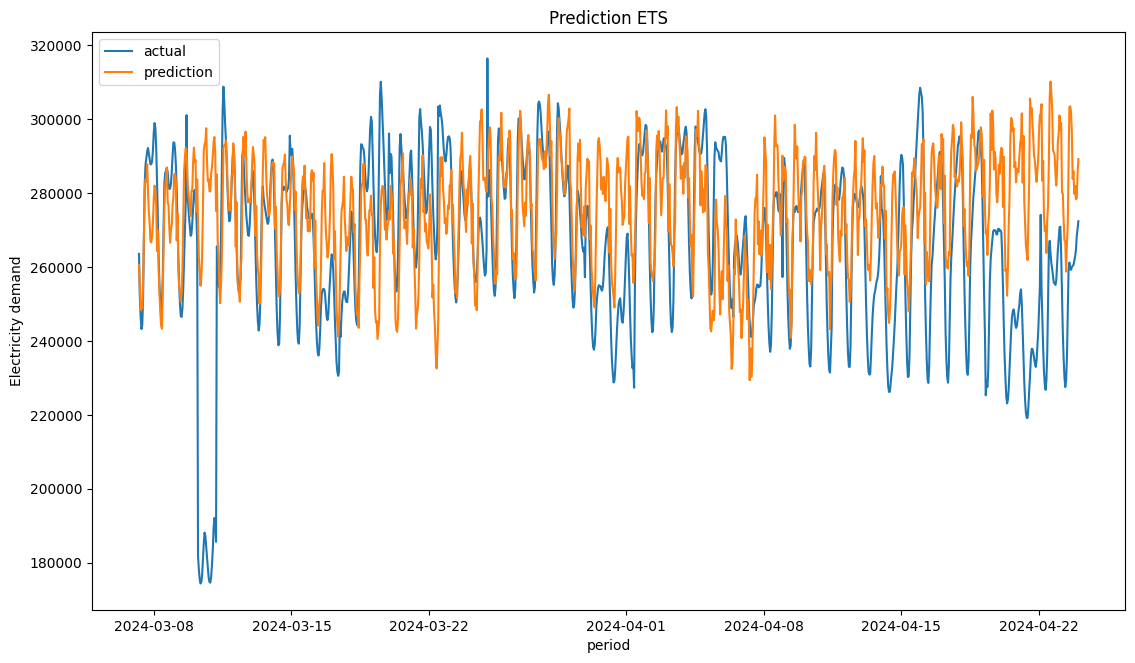

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(p[date_column], p[target_column]-1, label="actual")
ax.plot(p[date_column], non_zero, label="prediction")
ax.set_title("Prediction ETS")
ax.set_ylabel("Electricity demand")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [7]:
print_evaluation_metrics(non_zero, p[target_column]-1, train[target_column]-1)

Evaluation Metrics:
MSE: 576745912.22
RMSE: 24015.53
MAE: 16841.01
MAPE: 6.82
SMAPE: 6.40
MASE: 2.30


In [8]:
store_model(ets, "ets")

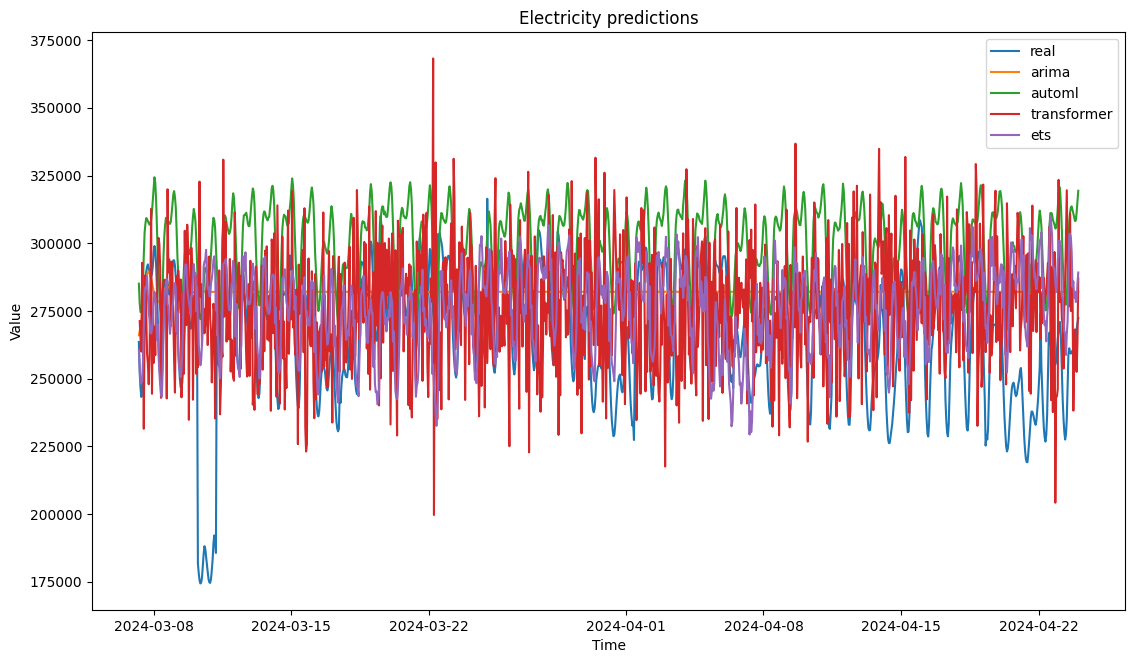

In [10]:
store_predictions_and_create_graph("ets", p[date_column], non_zero, p[target_column]-1, "Electricity")

In [16]:
param_grid = {"global_trend_option": ["linear", "loglinear", "flat", "logistic"]}
param_values = list(param_grid.values())

all_combinations = list(itertools.product(*param_values))

combinations_as_dicts = [
    dict(zip(param_grid.keys(), combination)) for combination in all_combinations
]

In [17]:
global_trend_options = ["linear", "loglinear", "flat", "logistic"]

dlt_scores = dict()


def dlt_function(grid: Dict[str, Any], date_column: str, target_column: str):
    """
    Create an DLT model with the specified parameters.

    Parameters:
    - grid (Dict[str, Any]): A dictionary containing the parameters for the ETS model.
    - date_column (str): The name of the date column.
    - target_column (str): The name of the target column.

    Returns:
    - An instance of the DLT model configured with the given parameters.
    """
    return DLT(
        date_col=date_column,
        response_col=target_column,
        prediction_percentiles=[5, 95],
        regressor_col=["value_30_hours_ago"],
        regressor_sign=["+"],
        regression_penalty="auto_ridge",
        damped_factor=0.8,
        seed=2,
        verbose=False,
        **ets_best_params,
        **grid
    )


with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {
        executor.submit(
            evaluate_grid, dlt_function, option, train, date_column, target_column
        ): option
        for option in combinations_as_dicts
    }
    for future in concurrent.futures.as_completed(futures):
        option, score = future.result()
        dlt_scores[json.dumps(option)] = score

chain 1 |          | 00:00 Status






































































































































































































chain 1 |██▌       | 00:01 Status



































































































































































chain 1 |█████     | 1:09:35 Iteration:   1 / 250 [  0%]  (Warmup)














































































































































































chain 1 |███████▌  | 2:19:30 Iteration: 100 / 250 [ 40%]  (Warmup)






































chain 1 |██████████| 2:27:07 Sampling completed                     
chain 2 |██████████| 2:27:07 Sampling completed                     
chain 3 |██████████| 2:27:07 Sampling completed                     
chain 4 |█████████









































































chain 1 |██████████| 2:32:19 Sampling completed                     
chain 2 |██████████| 2:32:19 Sampling completed                   
chain 3 |██████████| 2:32:19 Sampling completed                     
chain 4 |██████████| 2:32:19 Sampling completed                     






































































chain 1 |██████████| 2:33:58 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |██████████| 2:36:24 Sampling completed                     
chain 2 |██████████| 2:36:24 Sampling completed                     
chain 3 |██████████| 2:36:24 Sampling completed                     
chain 4 |██████████| 2:36:24 Sampling completed                     
















































































chain 1 |██████████| 2:51:43 Sampling completed                     
chain 2 |██████████| 2:51:43 Sampling completed                     
chain 3 |██████████| 2:51:43 Sampling completed                     
chain 4 |██████████| 2:51:43 Sampling completed                   

chain 1 |          | 00:00 Status























































chain 1 |██▌       | 00:02 Status



































































































































































































































chain 1 |█████     | 43:17 Iteration:   1 / 250 [  0%]  (Warmup)






































































































chain 1 |███████▌  | 1:26:15 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 1:52:30 Sampling completed                     
chain 2 |██████████| 1:52:30 Sampling completed                     
chain 3 |██████████| 1:52:30 Sampling completed                     
chain 4 |██████████| 1:52:30 Sampling completed                   








































































chain 1 |██████████| 1:52:23 Sampling completed                     
chain 2 |██████████| 1:52:23 Sampling completed                   
chain 3 |██████████| 1:52:23 Sampling completed                   
chain 4 |██████████| 1:52:23 Sampling completed                     


























































chain 1 |██████████| 1:37:51 Iteration: 200 / 250 [ 80%]  (Warmup)










chain 1 |██████████| 1:58:45 Sampling completed                   
chain 2 |██████████| 1:58:45 Sampling completed                     
chain 3 |██████████| 1:58:45 Sampling completed                     
chain 4 |██████████| 1:58:45 Sampling completed                     
































































chain 1 |          | 1:54:17 Iteration: 226 / 250 [ 90%]  (Sampling)














































































chain 1 |██████████| 2:09:01 Sampling completed                     
chain 2 |██████████| 2:09:01 Sampling completed                   
chain 3 |██████████| 2:09:01 Sampling completed                   
chain 4 |██████████| 2:09:01 Sampling completed                     




chain 1 |          | 00:00 Status








































chain 1 |██▌       | 00:01 Status






























































































































































































































chain 1 |█████     | 1:00:00 Iteration:   1 / 250 [  0%]  (Warmup)






















































































chain 1 |██████████| 2:07:34 Sampling completed                     
chain 2 |██████████| 2:07:34 Sampling completed                     
chain 3 |██████████| 2:07:34 Sampling completed                     
chain 4 |██████████| 2:07:34 Sampling completed                   




































































chain 1 |██████████| 2:10:44 Sampling completed                     
chain 2 |██████████| 2:10:44 Sampling completed                   
chain 3 |██████████| 2:10:44 Sampling completed                     
chain 4 |██████████| 2:10:44 Sampling completed                     



































































chain 1 |██████████| 2:16:04 Sampling completed                     
chain 2 |██████████| 2:16:04 Sampling completed                     
chain 3 |██████████| 2:16:04 Sampling completed                     
chain 4 |██████████| 2:16:04 Sampling completed                   












































































chain 1 |███████▌  | 1:59:09 Iteration: 100 / 250 [ 40%]  (Warmup)
































chain 1 |██████████| 2:17:49 Iteration: 200 / 250 [ 80%]  (Warmup)











































































chain 1 |██████████| 2:34:52 Sampling completed                     
chain 2 |██████████| 2:34:52 Sampling completed                     
chain 3 |██████████| 2:34:52 Sampling completed                     
chain 4 |██████████| 2:34:52 Sampling completed                   












chain 1 |          | 00:00 Status

















































chain 1 |██▌       | 00:01 Status


























































































































































chain 1 |█████     | 1:02:23 Iteration:   1 / 250 [  0%]  (Warmup)

































chain 1 |██████████| 2:18:32 Sampling completed                     
chain 2 |██████████| 2:18:32 Sampling completed                   
chain 3 |██████████| 2:18:32 Sampling completed                     
chain 4 |██████████| 2:18:32 Sampling completed                     





























































































chain 1 |██████████| 2:24:49 Sampling completed                     
chain 2 |██████████| 2:24:49 Sampling completed                     
chain 3 |██████████| 2:24:49 Sampling completed                     
chain 4 |██████████| 2:24:49 Sampling completed                     




























































































































































chain 1 |██████████| 2:33:03 Sampling completed                     
chain 2 |██████████| 2:33:03 Sampling completed                     
chain 3 |██████████| 2:33:03 Sampling completed                   
chain 4 |██████████| 2:33:03 Sampling completed                   














































































































































































chain 1 |███████▌  | 2:10:55 Iteration: 100 / 250 [ 40%]  (Warmup)













































chain 1 |██████████| 2:25:19 Iteration: 200 / 250 [ 80%]  (Warmup)



















































chain 1 |██████████| 2:35:39 Sampling completed                     
chain 2 |██████████| 2:35:39 Sampling completed                     
chain 3 |██████████| 2:35:39 Sampling completed                     
chain 4 |██████████| 2:35:39 Sampling completed                     

chain 1 |          | 00:00 Status



























chain 1 |██▌       | 00:00 Status








































































































chain 1 |██████████| 1:51:51 Sampling completed                     
chain 2 |██████████| 1:51:51 Sampling completed                   
chain 3 |██████████| 1:51:51 Sampling completed                   
chain 4 |██████████| 1:51:51 Sampling completed                   

chain 1 |██████████| 1:38:02 Sampling completed                     
chain 2 |██████████| 1:38:02 Sampling completed                   
chain 3 |██████████| 1:38:02 Sampling completed                   
chain 4 |██████████| 1:38:02 Sampling completed                   

































chain 1 |█████     | 31:23 Iteration:   1 / 250 [  0%]  (Warmup)


























chain 1 |██████████| 1:26:24 Sampling completed                   
chain 2 |██████████| 1:26:24 Sampling completed                   
chain 3 |██████████| 1:26:24 Sampling completed                     
chain 4 |██████████| 1:26:24 Sampling completed                     














chain 1 |███████▌  | 47:33 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |██████████| 51:15 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |██████████| 54:47 Sampling completed                     
chain 2 |██████████| 54:47 Sampling completed                     
chain 3 |██████████| 54:47 Sampling completed                     
chain 4 |██████████| 54:47 Sampling completed                     

In [18]:
dlt_best_params = json.loads(min(dlt_scores, key=dlt_scores.get))
dlt_best_params

{'global_trend_option': 'flat'}

In [40]:
dlt = DLT(
    date_col=date_column,
    response_col=target_column,
    prediction_percentiles=[5, 95],
    regressor_col=["value_30_hours_ago"],
    regressor_sign=["+"],
    regression_penalty="auto_ridge",
    damped_factor=0.8,
    seed=2,
    verbose=False,
    **ets_best_params,
    **dlt_best_params
)

dlt.fit(train)


chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





chain 1 |█████     | 14:25 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 29:36 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 34:18 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |██████████| 38:18 Sampling completed                     
chain 2 |██████████| 38:18 Sampling completed                     
chain 3 |██████████| 38:18 Sampling completed                     
chain 4 |██████████| 38:18 Sampling completed                     

In [12]:
p = dlt.predict(df=test[[date_column, "value_30_hours_ago"]])
p = p.merge(test, on=date_column, how="left")

In [13]:
non_zero = []
 
for i in p["prediction"]:
    removed_initial_one = i-1
    if removed_initial_one == 0:
        non_zero.append(removed_initial_one+sys.float_info.min)
    else:
        non_zero.append(removed_initial_one)

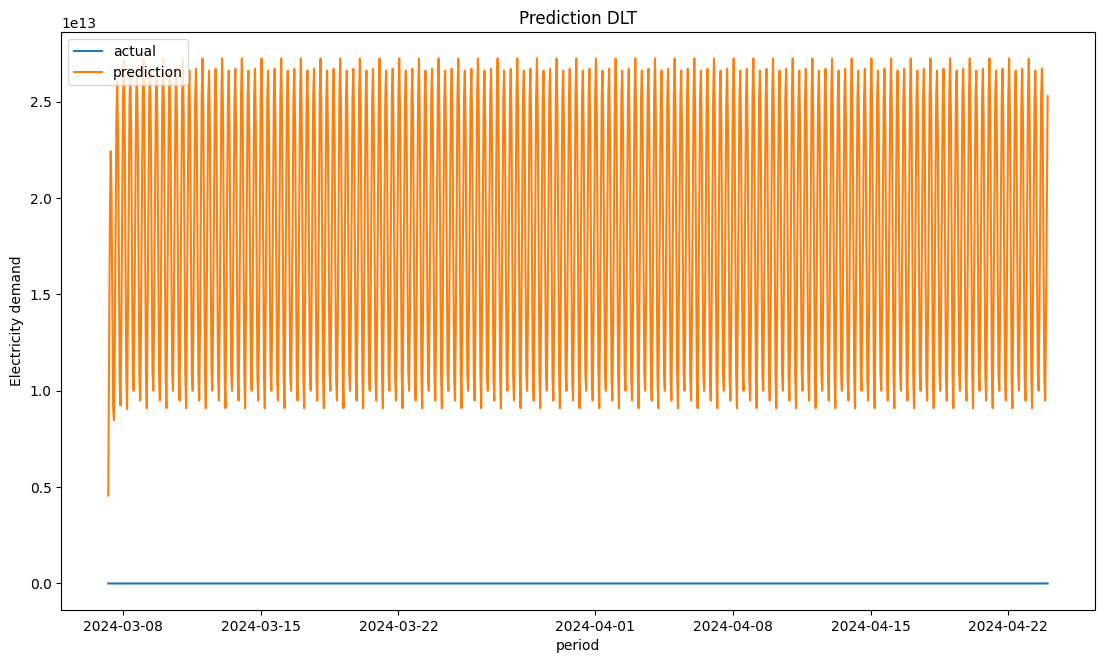

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(p[date_column], p[target_column]-1, label="actual")
ax.plot(p[date_column], non_zero, label="prediction")
ax.set_title("Prediction DLT")
ax.set_ylabel("Electricity demand")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [15]:
print_evaluation_metrics(non_zero, p[target_column]-1, train[target_column]-1)

Evaluation Metrics:
MSE: 373950647950852433951850496.00
RMSE: 19337803596863.12
MAE: 18311556640703.11
MAPE: 6929387695.22
SMAPE: 200.00
MASE: 2499020967.03


In [16]:
store_model(dlt, "dlt")

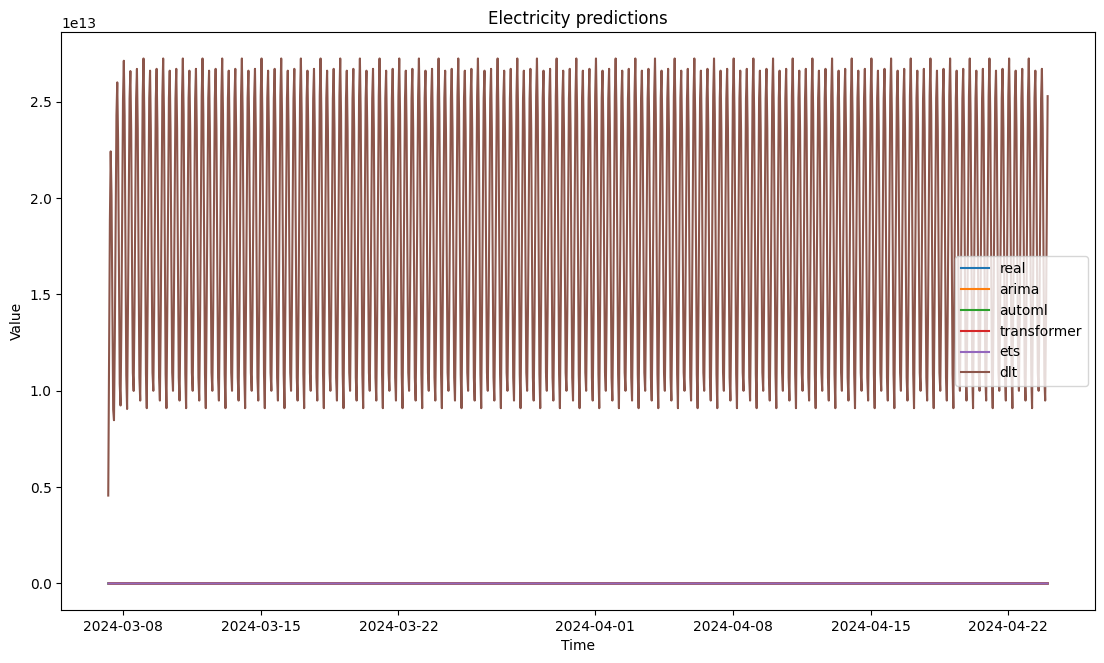

In [17]:
store_predictions_and_create_graph("dlt", p[date_column], non_zero, p[target_column]-1, "Electricity")

In [25]:
seasonality = [12, 24, 7*24]

def all_possible_sublists(lst):
    n = len(lst)
    sublists = []
     
    for start in range(n):
        for end in range(start + 1, n + 1):
            sublists.append(lst[start:end])
     
    return sublists


sublists = all_possible_sublists(seasonality)
param_grid = {"seasonality": sublists, "seed": [1,2,3,4,5]}
param_values = list(param_grid.values())

all_combinations = list(itertools.product(*param_values))

combinations_as_dicts = [
    dict(zip(param_grid.keys(), combination)) for combination in all_combinations
]

In [26]:
ktr_scores = dict()


def ktr_function(grid: Dict[str, Any], date_column: str, target_column: str):
    """
    Create an DLT model with the specified parameters.

    Parameters:
    - grid (Dict[str, Any]): A dictionary containing the parameters for the ETS model.
    - date_column (str): The name of the date column.
    - target_column (str): The name of the target column.

    Returns:
    - An instance of the DLT model configured with the given parameters.
    """
    return KTR(
    date_col=date_column,
    response_col=target_column,
    prediction_percentiles=[5, 95],
    regressor_col=["value_30_hours_ago"],
    verbose=False,
    **grid
)

for option in combinations_as_dicts:
    _, score = evaluate_grid(ktr_function, option, train, date_column, target_column)
    ktr_scores[json.dumps(option)] = score
    with open("ktr_scores.json", "w") as f:
            json.dump(ktr_scores, f)

2024-05-02 16:01:34 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
/home/samuell/.local/lib/python3.10/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)
2024-05-02 16:02:00 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
2024-05-02 16:02:28 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
2024-05-02 16:02:56 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
2024-05-02 16:03:21 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
2024-05-02 16:03:51 - orbit - INFO - Optimizi

In [27]:
ktr_best_params = json.loads(min(ktr_scores, key=ktr_scores.get))
ktr_best_params

{'seasonality': [12], 'seed': 1}

In [28]:
ktr = KTR(
    date_col=date_column,
    response_col=target_column,
    prediction_percentiles=[5, 95],
    regressor_col=["value_30_hours_ago"],
    verbose=False,
    **ktr_best_params
)

ktr.fit(df=train)

2024-05-02 17:07:11 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


In [19]:
p = ktr.predict(df=test[[date_column, "value_30_hours_ago"]])
p = p.merge(test, on=date_column, how="left")

In [20]:
non_zero = []
 
for i in p["prediction"]:
    removed_initial_one = i-1
    if removed_initial_one == 0:
        non_zero.append(removed_initial_one+sys.float_info.min)
    else:
        non_zero.append(removed_initial_one)

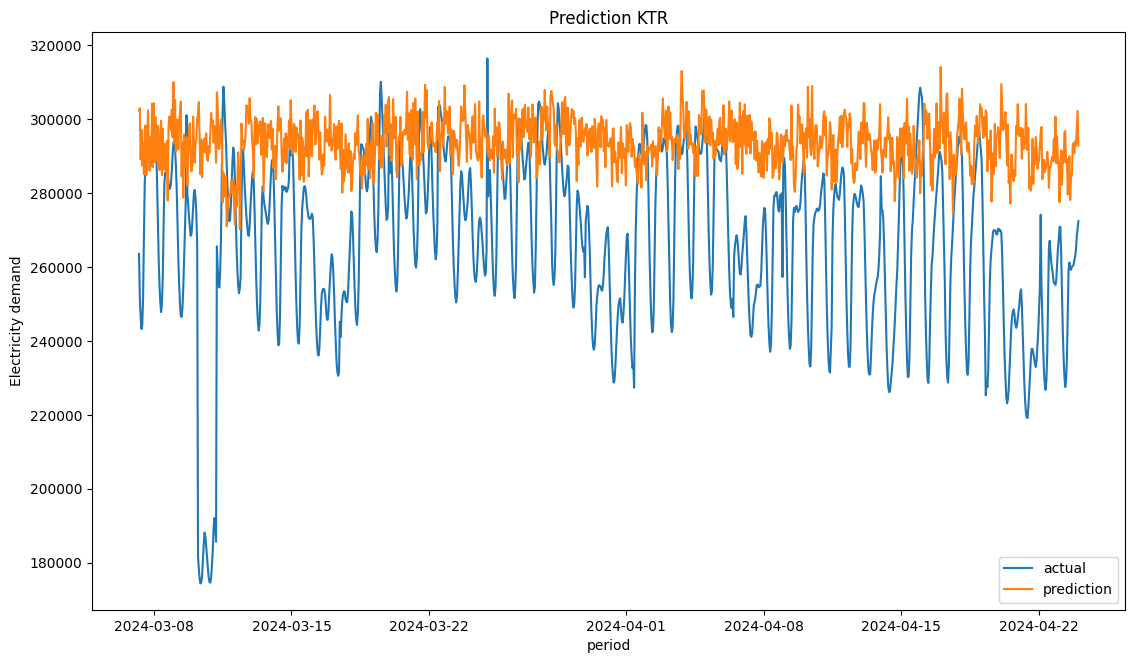

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(p[date_column], p[target_column]-1, label="actual")
ax.plot(p[date_column], non_zero, label="prediction")
ax.set_title("Prediction KTR")
ax.set_ylabel("Electricity demand")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [22]:
print_evaluation_metrics(non_zero, p[target_column]-1, train[target_column]-1)

Evaluation Metrics:
MSE: 1297975007.91
RMSE: 36027.42
MAE: 28396.40
MAPE: 11.53
SMAPE: 10.46
MASE: 3.88


In [23]:
store_model(ktr, "ktr")

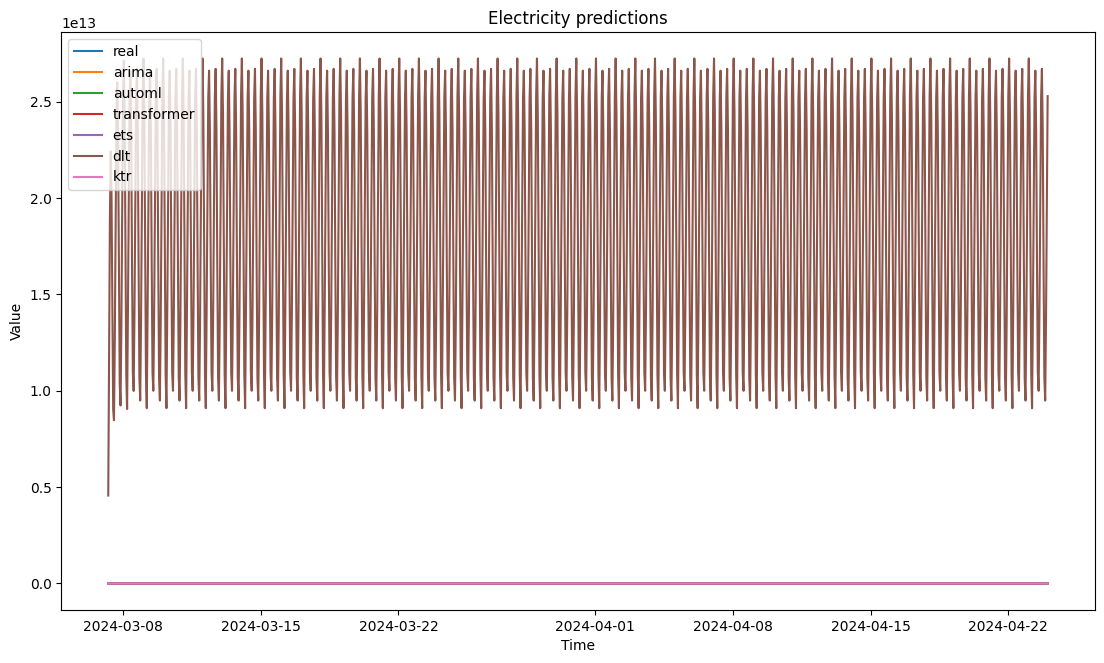

In [24]:
store_predictions_and_create_graph("ktr", p[date_column], non_zero, p[target_column]-1, "Electricity")